In [6]:
# pip install pyvirtualdisplay

Note: you may need to restart the kernel to use updated packages.


In [7]:
# pip -q install pyglet

Note: you may need to restart the kernel to use updated packages.


In [8]:
# pip -q install pyopengl

Note: you may need to restart the kernel to use updated packages.


In [11]:
# pip install box2d --user

Note: you may need to restart the kernel to use updated packages.


In [18]:
########## utils
import gym
import numpy as np
#from agent import Agent
#from utils import plot_learning_curve, manage_memory
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [19]:
####noise
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)


In [20]:
####Network
class CriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=512, fc2_dims=512):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    # have to define inputs as a tuple because the model.save() function
    # trips an error when trying to save a call function with two inputs.
    def call(self, inputs):
        state, action = inputs
        action_value = self.fc1(tf.concat([state, action], axis=1))
        action_value = self.fc2(action_value)

        q = self.q(action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512, n_actions=2):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

In [21]:
######buffer
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [22]:
##### Agent
class Agent:
    def __init__(self, input_dims, alpha=0.001, beta=0.002, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
                 fc1=400, fc2=300, batch_size=64, noise=0.1,
                 chkpt_dir='models/ddpg/'):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.noise = noise
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions=n_actions,
                                  fc1_dims=fc1, fc2_dims=fc2)
        self.critic = CriticNetwork(n_actions=n_actions,
                                    fc1_dims=fc1, fc2_dims=fc2)
        self.target_actor = ActorNetwork(n_actions=n_actions,
                                         fc1_dims=fc1, fc2_dims=fc2)
        self.target_critic = CriticNetwork(n_actions=n_actions,
                                           fc1_dims=fc1, fc2_dims=fc2)

        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i]*(1-tau))
        self.target_critic.set_weights(weights)

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir+'actor')
        self.target_actor.save(self.chkpt_dir+'target_actor')
        self.critic.save(self.chkpt_dir+'critic')
        self.target_critic.save(self.chkpt_dir+'target_critic')

    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir+'actor')
        self.target_actor = \
            keras.models.load_model(self.chkpt_dir+'target_actor')
        self.critic = keras.models.load_model(self.chkpt_dir+'critic')
        self.target_critic = \
            keras.models.load_model(self.chkpt_dir+'target_critic')

    def choose_action(self, observation, evaluate=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        actions = self.actor(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions],
                                        mean=0.0, stddev=self.noise)
        # note that if the env has an action > 1, we have to multiply by
        # max action at some point
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)

        return actions[0]

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
            self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                (states_, target_actions)), 1)
            critic_value = tf.squeeze(self.critic((states, actions)), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = keras.losses.MSE(target, critic_value)
        params = self.critic.trainable_variables
        grads = tape.gradient(critic_loss, params)
        self.critic.optimizer.apply_gradients(zip(grads, params))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic((states, new_policy_actions))
            actor_loss = tf.math.reduce_mean(actor_loss)
        params = self.actor.trainable_variables
        grads = tape.gradient(actor_loss, params)
        self.actor.optimizer.apply_gradients(zip(grads, params))

        self.update_network_parameters()

... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 0 score -107.9 avg score -107.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1 score -105.4 avg score -106.7
episode 2 score -149.2 avg score -120.9
episode 3 score -171.6 avg score -133.5
episode 4 score -104.8 avg score -127.8
episode 5 score -105.1 avg score -124.0
episode 6 score -105.9 avg score -121.4
episode 7 score -105.9 avg score -119.5
episode 8 score -105.1 avg score -117.9
episode 9 score -106.2 avg score -116.7
episode 10 score -106.0 avg score -115.7
epi

episode 185 score -98.3 avg score -124.4
episode 186 score -139.4 avg score -124.5
episode 187 score -122.1 avg score -124.5
episode 188 score -125.6 avg score -124.7
episode 189 score -104.2 avg score -124.6
episode 190 score -133.3 avg score -124.7
episode 191 score -136.1 avg score -124.7
episode 192 score -101.6 avg score -124.5
episode 193 score -143.7 avg score -124.5
episode 194 score -131.5 avg score -124.2
episode 195 score -132.6 avg score -124.3
episode 196 score -165.4 avg score -124.6
episode 197 score -135.0 avg score -124.8
episode 198 score -131.4 avg score -124.7
episode 199 score -139.3 avg score -124.9
episode 200 score -134.8 avg score -125.1
episode 201 score -108.6 avg score -125.0
episode 202 score -109.2 avg score -124.6
episode 203 score -133.2 avg score -124.8
episode 204 score -141.4 avg score -124.1
episode 205 score -137.6 avg score -123.9
episode 206 score -116.0 avg score -123.7
episode 207 score -136.7 avg score -123.6
episode 208 score -109.2 avg score 

INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 348 score 88.7 avg score -103.1
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 349 score -91.2 avg score -102.7
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 350 score -51.7 avg score -102.1
... saving models ...
INFO:tensorflow:Assets written to: models/dd

... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 413 score -107.6 avg score -93.1
episode 414 score -104.4 avg score -93.5
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 415 score -81.9 avg score -92.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 416 score -77.8 avg score -92.6
... 

INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 447 score 1.9 avg score -71.3
episode 448 score -65.6 avg score -72.8
episode 449 score -85.8 avg score -72.7
episode 450 score 42.5 avg score -71.8
episode 451 score -125.4 avg score -72.3
episode 452 score -102.6 avg score -73.1
episode 453 score -93.7 avg score -73.3
episode 454 score -62.5 avg score -72.4
episode 455 score -59.1 avg score -72.5
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 456 score 155.1 avg score -69.7
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddp

INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 486 score -25.8 avg score -53.7
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 487 score -88.3 avg score -53.4
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 488 score 27.3 avg score -51.7
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/

INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 514 score -100.0 avg score -25.6
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 515 score -24.0 avg score -25.0
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 516 score -68.0 avg score -24.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddp

episode 672 score -68.2 avg score -82.2
episode 673 score -67.0 avg score -83.3
episode 674 score -48.2 avg score -83.9
episode 675 score -54.3 avg score -84.1
episode 676 score -72.5 avg score -84.5
episode 677 score -38.0 avg score -84.4
episode 678 score -38.8 avg score -84.9
episode 679 score -49.6 avg score -85.4
episode 680 score -74.6 avg score -85.5
episode 681 score -73.3 avg score -85.7
episode 682 score -26.9 avg score -84.9
episode 683 score -61.9 avg score -84.8
episode 684 score -51.6 avg score -84.1
episode 685 score -80.8 avg score -83.7
episode 686 score -32.1 avg score -82.8
episode 687 score -72.3 avg score -82.3
episode 688 score -63.2 avg score -81.6
episode 689 score -9.2 avg score -80.3
episode 690 score 35.7 avg score -78.7
episode 691 score 77.8 avg score -76.7
episode 692 score -24.2 avg score -75.7
episode 693 score 40.6 avg score -74.1
episode 694 score -14.9 avg score -73.0
episode 695 score 14.7 avg score -71.5
episode 696 score 33.6 avg score -69.9
episod

episode 795 score -49.6 avg score -24.8
episode 796 score -24.3 avg score -25.3
episode 797 score -50.4 avg score -26.5
episode 798 score -43.5 avg score -27.4
episode 799 score -43.0 avg score -28.4
episode 800 score 75.5 avg score -27.3
episode 801 score 82.2 avg score -26.5
episode 802 score -59.3 avg score -26.6
episode 803 score -105.1 avg score -28.6
episode 804 score -108.5 avg score -30.3
episode 805 score -35.0 avg score -33.4
episode 806 score -89.1 avg score -35.4
episode 807 score -113.2 avg score -37.6
episode 808 score -110.4 avg score -38.8
episode 809 score -88.9 avg score -39.7
episode 810 score -106.7 avg score -40.7
episode 811 score -104.6 avg score -41.8
episode 812 score -103.6 avg score -42.4
episode 813 score -102.5 avg score -43.2
episode 814 score -107.1 avg score -43.6
episode 815 score -108.1 avg score -43.8
episode 816 score -109.3 avg score -44.5
episode 817 score -104.6 avg score -44.9
episode 818 score -102.8 avg score -45.4
episode 819 score -107.7 avg 

episode 897 score -39.4 avg score -0.1
episode 898 score -112.0 avg score -0.8
episode 899 score -111.6 avg score -1.5
episode 900 score -47.9 avg score -2.7
episode 901 score -29.0 avg score -3.8
episode 902 score -0.3 avg score -3.2
episode 903 score -61.5 avg score -2.8
episode 904 score -59.0 avg score -2.3
episode 905 score -66.2 avg score -2.6
episode 906 score -63.7 avg score -2.3
episode 907 score -40.4 avg score -1.6
episode 908 score -69.7 avg score -1.2
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 909 score 58.0 avg score 0.3
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:t

episode 980 score 135.1 avg score -16.1
episode 981 score -87.4 avg score -15.8
episode 982 score -34.2 avg score -16.2
episode 983 score -109.6 avg score -16.9
episode 984 score -26.5 avg score -16.8
episode 985 score -21.6 avg score -17.6
episode 986 score -97.0 avg score -17.8
episode 987 score -103.1 avg score -18.8
episode 988 score -44.7 avg score -18.1
episode 989 score -100.4 avg score -20.0
episode 990 score 66.4 avg score -19.7
episode 991 score -43.2 avg score -20.7
episode 992 score -47.1 avg score -20.7
episode 993 score 157.5 avg score -19.6
episode 994 score 124.9 avg score -18.0
episode 995 score 107.0 avg score -16.2
episode 996 score -69.5 avg score -16.5
episode 997 score 0.7 avg score -16.1
episode 998 score -101.5 avg score -16.0
episode 999 score -104.3 avg score -15.9
episode 1000 score -30.6 avg score -15.7
episode 1001 score -104.0 avg score -16.5
episode 1002 score -96.1 avg score -17.4
episode 1003 score -12.5 avg score -16.9
episode 1004 score -52.1 avg scor

INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1071 score 175.5 avg score 33.4
episode 1072 score -48.4 avg score 32.6
episode 1073 score -52.6 avg score 31.9
episode 1074 score 59.7 avg score 32.6
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1075 score 56.5 avg score 33.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1076 score -100.9 avg score 34.0
episode 1077 score -67.5 avg score 33.3
episode 1078 score -43.9 avg score 3

episode 1212 score 291.5 avg score 32.9
episode 1213 score -79.2 avg score 32.4
episode 1214 score 291.9 avg score 36.3
episode 1215 score 42.9 avg score 37.7
episode 1216 score -118.5 avg score 37.5
episode 1217 score -120.4 avg score 36.2
episode 1218 score -110.3 avg score 36.6
episode 1219 score -108.4 avg score 36.4
episode 1220 score -63.9 avg score 35.9
episode 1221 score -106.4 avg score 35.1
episode 1222 score -107.8 avg score 34.8
episode 1223 score -108.5 avg score 32.1
episode 1224 score -107.4 avg score 31.8
episode 1225 score -106.5 avg score 27.8
episode 1226 score -142.6 avg score 27.4
episode 1227 score -61.9 avg score 27.7
episode 1228 score 44.1 avg score 29.3
episode 1229 score 5.0 avg score 28.6
episode 1230 score -106.1 avg score 26.6
episode 1231 score -100.9 avg score 26.6
episode 1232 score -85.5 avg score 25.7
episode 1233 score 246.0 avg score 25.3
episode 1234 score -39.6 avg score 22.1
episode 1235 score 12.0 avg score 21.9
episode 1236 score 273.1 avg scor

episode 1292 score -85.2 avg score 46.1
episode 1293 score -98.0 avg score 45.2
episode 1294 score -99.5 avg score 45.2
episode 1295 score -99.8 avg score 41.3
episode 1296 score -9.3 avg score 38.3
episode 1297 score -98.3 avg score 34.5
episode 1298 score 285.3 avg score 34.4
episode 1299 score -104.5 avg score 30.4
episode 1300 score 42.0 avg score 30.3
episode 1301 score -8.4 avg score 27.3
episode 1302 score -36.2 avg score 27.3
episode 1303 score 159.3 avg score 25.9
episode 1304 score 16.3 avg score 26.9
episode 1305 score -74.0 avg score 25.1
episode 1306 score -79.8 avg score 23.2
episode 1307 score -71.6 avg score 22.7
episode 1308 score -38.8 avg score 22.3
episode 1309 score -58.8 avg score 20.9
episode 1310 score -134.6 avg score 20.5
episode 1311 score -80.6 avg score 20.6
episode 1312 score 279.4 avg score 20.4
episode 1313 score -89.5 avg score 20.3
episode 1314 score 282.5 avg score 20.2
episode 1315 score 274.4 avg score 22.6
episode 1316 score 44.0 avg score 24.2
epi

INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1484 score 294.0 avg score 79.3
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1485 score 2.2 avg score 80.6
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 1486 score 59.7 avg score 82.4
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/cr

episode 1596 score -71.9 avg score 27.6
episode 1597 score -50.6 avg score 27.8
episode 1598 score -90.3 avg score 25.6
episode 1599 score 53.5 avg score 24.5
episode 1600 score 5.1 avg score 25.0
episode 1601 score 72.9 avg score 26.1
episode 1602 score 294.7 avg score 28.3
episode 1603 score -66.5 avg score 28.0
episode 1604 score -65.3 avg score 26.2
episode 1605 score 39.8 avg score 26.5
episode 1606 score 60.0 avg score 27.5
episode 1607 score 26.8 avg score 27.7
episode 1608 score 297.5 avg score 31.5
episode 1609 score 33.1 avg score 31.9
episode 1610 score 44.6 avg score 32.4
episode 1611 score -31.3 avg score 29.3
episode 1612 score 40.2 avg score 29.0
episode 1613 score 293.3 avg score 33.1
episode 1614 score 296.6 avg score 37.1
episode 1615 score 64.2 avg score 38.6
episode 1616 score -12.3 avg score 39.5
episode 1617 score 295.8 avg score 43.5
episode 1618 score 100.7 avg score 45.6
episode 1619 score 297.7 avg score 49.5
episode 1620 score -8.9 avg score 50.3
episode 1621

episode 1788 score 11.3 avg score 85.4
episode 1789 score 189.3 avg score 88.3
episode 1790 score -66.2 avg score 87.7
episode 1791 score 33.9 avg score 85.1
episode 1792 score -53.4 avg score 81.7
episode 1793 score -70.1 avg score 81.2
episode 1794 score 168.4 avg score 80.3
episode 1795 score 293.5 avg score 81.2
episode 1796 score -9.5 avg score 78.8
episode 1797 score -56.5 avg score 79.1
episode 1798 score 2.2 avg score 78.3
episode 1799 score -61.3 avg score 78.4
episode 1800 score -50.8 avg score 75.5
episode 1801 score -64.0 avg score 75.3
episode 1802 score -41.7 avg score 72.0
episode 1803 score -52.2 avg score 71.1
episode 1804 score -59.3 avg score 67.7
episode 1805 score -63.9 avg score 64.2
episode 1806 score -7.9 avg score 63.1
episode 1807 score 61.5 avg score 60.7
episode 1808 score 127.3 avg score 59.1
episode 1809 score -24.8 avg score 57.8
episode 1810 score -67.7 avg score 54.3
episode 1811 score -70.0 avg score 53.3
episode 1812 score 127.1 avg score 54.1
episode

episode 1995 score -66.6 avg score 15.0
episode 1996 score -26.4 avg score 15.1
episode 1997 score 299.2 avg score 17.7
episode 1998 score 294.8 avg score 21.4
episode 1999 score 293.9 avg score 25.3
episode 2000 score 26.7 avg score 26.6
episode 2001 score 296.2 avg score 30.1
episode 2002 score 18.5 avg score 31.3
episode 2003 score -5.0 avg score 31.5
episode 2004 score 75.8 avg score 29.3
episode 2005 score 60.9 avg score 30.6
episode 2006 score 298.4 avg score 33.1
episode 2007 score 77.9 avg score 34.6
episode 2008 score -99.5 avg score 33.9
episode 2009 score -98.4 avg score 33.7
episode 2010 score 14.9 avg score 33.8
episode 2011 score -49.5 avg score 32.6
episode 2012 score 124.3 avg score 30.9
episode 2013 score 57.6 avg score 28.4
episode 2014 score 296.3 avg score 31.5
episode 2015 score -66.2 avg score 30.2
episode 2016 score -66.5 avg score 30.4
episode 2017 score 62.1 avg score 31.0
episode 2018 score -87.8 avg score 30.7
episode 2019 score -46.2 avg score 30.7
episode 2

episode 2203 score -68.4 avg score 1.7
episode 2204 score 294.8 avg score 5.8
episode 2205 score 296.5 avg score 10.4
episode 2206 score -37.5 avg score 11.6
episode 2207 score 173.9 avg score 14.8
episode 2208 score 299.5 avg score 19.0
episode 2209 score -90.4 avg score 18.7
episode 2210 score -14.3 avg score 19.0
episode 2211 score 294.9 avg score 21.1
episode 2212 score 58.7 avg score 22.1
episode 2213 score 291.7 avg score 25.5
episode 2214 score 294.9 avg score 29.0
episode 2215 score -102.7 avg score 28.4
episode 2216 score -55.0 avg score 28.6
episode 2217 score 297.4 avg score 31.8
episode 2218 score -95.1 avg score 30.9
episode 2219 score -103.5 avg score 29.1
episode 2220 score 100.3 avg score 28.5
episode 2221 score -107.9 avg score 25.9
episode 2222 score -102.9 avg score 25.1
episode 2223 score -110.3 avg score 24.5
episode 2224 score -82.6 avg score 23.8
episode 2225 score 288.5 avg score 27.4
episode 2226 score 73.3 avg score 28.7
episode 2227 score -14.0 avg score 28.9

INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2379 score 292.0 avg score 117.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2380 score 291.6 avg score 118.0
episode 2381 score -68.3 avg score 117.0
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2382 score 295.5 avg score 119.7
episode 2383 score -30.3 avg score 116.4
episode 2384 score -24.0 avg score 116.3
ep

episode 2419 score 291.1 avg score 159.1
episode 2420 score -20.7 avg score 158.0
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2421 score 135.1 avg score 160.1
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2422 score 295.0 avg score 163.2
episode 2423 score -78.1 avg score 162.9
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets writte

episode 2582 score 298.6 avg score 51.5
episode 2583 score 59.4 avg score 52.7
episode 2584 score 172.2 avg score 54.5
episode 2585 score -38.9 avg score 54.4
episode 2586 score 296.7 avg score 57.7
episode 2587 score 89.1 avg score 59.1
episode 2588 score 36.8 avg score 59.5
episode 2589 score 5.0 avg score 56.6
episode 2590 score -46.7 avg score 56.4
episode 2591 score -16.9 avg score 56.7
episode 2592 score -48.2 avg score 56.4
episode 2593 score -40.9 avg score 56.0
episode 2594 score -102.5 avg score 54.9
episode 2595 score -47.1 avg score 55.4
episode 2596 score 18.9 avg score 56.2
episode 2597 score 1.0 avg score 54.5
episode 2598 score 300.2 avg score 56.1
episode 2599 score 178.3 avg score 57.0
episode 2600 score 13.0 avg score 57.6
episode 2601 score -75.7 avg score 56.8
episode 2602 score 299.9 avg score 60.1
episode 2603 score 188.1 avg score 61.4
episode 2604 score 29.1 avg score 61.6
episode 2605 score -2.7 avg score 62.1
episode 2606 score -41.7 avg score 60.1
episode 26

episode 2787 score 295.8 avg score 164.1
episode 2788 score -1.3 avg score 163.7
episode 2789 score -127.6 avg score 159.9
episode 2790 score 296.3 avg score 161.8
episode 2791 score 40.7 avg score 161.2
episode 2792 score 294.3 avg score 163.4
episode 2793 score -149.2 avg score 159.3
episode 2794 score -221.3 avg score 157.2
episode 2795 score 10.7 avg score 154.4
episode 2796 score 104.9 avg score 152.5
episode 2797 score -135.3 avg score 151.7
episode 2798 score -151.5 avg score 149.7
episode 2799 score 48.7 avg score 151.0
episode 2800 score -99.0 avg score 149.9
episode 2801 score -153.2 avg score 147.7
episode 2802 score -77.8 avg score 144.0
episode 2803 score 30.9 avg score 141.4
episode 2804 score -47.4 avg score 139.6
episode 2805 score -77.0 avg score 137.0
episode 2806 score 5.3 avg score 134.1
episode 2807 score -93.2 avg score 133.3
episode 2808 score 147.1 avg score 133.2
episode 2809 score -98.6 avg score 132.0
episode 2810 score 23.6 avg score 133.5
episode 2811 score

INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2915 score 122.3 avg score 187.4
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2916 score 293.0 avg score 191.3
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 2917 score 288.8 avg score 195.0
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/d

episode 3046 score -19.9 avg score 194.6
episode 3047 score 296.0 avg score 196.7
episode 3048 score 291.9 avg score 199.5
episode 3049 score 183.3 avg score 199.8
episode 3050 score 295.1 avg score 201.2
episode 3051 score -41.6 avg score 201.7
episode 3052 score 285.5 avg score 204.7
episode 3053 score -22.7 avg score 204.0
episode 3054 score 297.5 avg score 207.4
episode 3055 score 288.4 avg score 207.4
episode 3056 score 119.2 avg score 205.6
episode 3057 score 137.1 avg score 204.0
episode 3058 score 81.8 avg score 204.3
episode 3059 score -69.2 avg score 200.7
episode 3060 score 54.1 avg score 200.0
episode 3061 score 159.5 avg score 198.6
episode 3062 score 93.6 avg score 200.6
episode 3063 score 293.4 avg score 204.1
episode 3064 score 169.5 avg score 206.1
episode 3065 score 295.1 avg score 206.0
episode 3066 score 299.0 avg score 206.1
episode 3067 score -6.1 avg score 203.0
episode 3068 score 297.5 avg score 204.8
episode 3069 score -28.3 avg score 201.6
episode 3070 score 1

episode 3248 score -103.6 avg score 85.8
episode 3249 score -83.6 avg score 82.0
episode 3250 score 159.1 avg score 83.0
episode 3251 score 299.6 avg score 86.9
episode 3252 score 299.7 avg score 86.8
episode 3253 score 300.5 avg score 89.7
episode 3254 score 80.9 avg score 87.5
episode 3255 score 294.2 avg score 91.0
episode 3256 score 294.0 avg score 90.9
episode 3257 score -54.5 avg score 87.4
episode 3258 score -90.6 avg score 86.7
episode 3259 score -94.7 avg score 82.8
episode 3260 score -92.2 avg score 80.6
episode 3261 score -96.1 avg score 76.7
episode 3262 score 299.4 avg score 76.8
episode 3263 score 301.3 avg score 76.8
episode 3264 score -2.7 avg score 73.9
episode 3265 score 299.1 avg score 74.1
episode 3266 score -98.9 avg score 72.1
episode 3267 score -109.4 avg score 68.1
episode 3268 score 303.7 avg score 68.2
episode 3269 score 166.6 avg score 70.6
episode 3270 score 302.7 avg score 73.6
episode 3271 score 302.4 avg score 76.4
episode 3272 score -57.4 avg score 72.9


episode 3450 score 269.0 avg score -15.5
episode 3451 score 277.0 avg score -11.6
episode 3452 score 265.5 avg score -7.9
episode 3453 score 85.0 avg score -5.9
episode 3454 score -30.8 avg score -5.4
episode 3455 score 146.4 avg score -3.0
episode 3456 score 278.0 avg score 0.9
episode 3457 score -46.2 avg score 1.4
episode 3458 score -36.1 avg score 2.1
episode 3459 score 281.8 avg score 4.6
episode 3460 score -101.7 avg score 4.5
episode 3461 score -85.2 avg score 4.6
episode 3462 score -94.4 avg score 4.6
episode 3463 score 289.1 avg score 8.5
episode 3464 score -101.9 avg score 8.5
episode 3465 score -97.6 avg score 8.4
episode 3466 score -98.7 avg score 8.3
episode 3467 score -96.2 avg score 8.1
episode 3468 score -96.4 avg score 7.2
episode 3469 score -108.1 avg score 7.0
episode 3470 score -102.6 avg score 6.9
episode 3471 score -102.6 avg score 6.9
episode 3472 score -97.8 avg score 7.0
episode 3473 score -98.2 avg score 7.1
episode 3474 score -85.8 avg score 7.2
episode 3475 

episode 3651 score -128.9 avg score -65.3
episode 3652 score -129.6 avg score -65.6
episode 3653 score -130.7 avg score -65.9
episode 3654 score -123.8 avg score -66.1
episode 3655 score -135.8 avg score -66.3
episode 3656 score -129.7 avg score -66.5
episode 3657 score -124.9 avg score -66.5
episode 3658 score -124.8 avg score -66.1
episode 3659 score -127.8 avg score -65.9
episode 3660 score -126.5 avg score -65.3
episode 3661 score -126.5 avg score -64.9
episode 3662 score -126.8 avg score -64.6
episode 3663 score -131.2 avg score -64.2
episode 3664 score -127.7 avg score -64.2
episode 3665 score -122.4 avg score -64.2
episode 3666 score -122.2 avg score -64.2
episode 3667 score -128.2 avg score -63.1
episode 3668 score -125.9 avg score -62.8
episode 3669 score -129.9 avg score -62.3
episode 3670 score -128.0 avg score -62.9
episode 3671 score -125.3 avg score -64.0
episode 3672 score -121.8 avg score -65.0
episode 3673 score -125.9 avg score -67.2
episode 3674 score -125.4 avg scor

episode 3845 score -70.5 avg score -38.9
episode 3846 score 107.3 avg score -36.6
episode 3847 score -40.4 avg score -35.7
episode 3848 score -49.6 avg score -34.9
episode 3849 score -43.7 avg score -34.1
episode 3850 score -39.3 avg score -33.3
episode 3851 score -28.1 avg score -32.2
episode 3852 score -34.5 avg score -31.4
episode 3853 score -63.6 avg score -30.7
episode 3854 score -2.8 avg score -29.6
episode 3855 score -69.5 avg score -29.0
episode 3856 score -19.8 avg score -28.0
episode 3857 score -84.1 avg score -27.5
episode 3858 score -52.8 avg score -26.6
episode 3859 score 10.7 avg score -25.3
episode 3860 score 60.0 avg score -23.3
episode 3861 score -52.5 avg score -22.6
episode 3862 score 278.5 avg score -18.5
episode 3863 score 60.7 avg score -16.6
episode 3864 score -5.0 avg score -15.3
episode 3865 score 2.8 avg score -13.8
episode 3866 score -46.3 avg score -12.9
episode 3867 score -26.1 avg score -11.7
episode 3868 score -9.3 avg score -10.3
episode 3869 score 22.8 

episode 4045 score -116.9 avg score -3.9
episode 4046 score -118.1 avg score -4.5
episode 4047 score -127.5 avg score -5.0
episode 4048 score -128.8 avg score -5.1
episode 4049 score -129.5 avg score -5.8
episode 4050 score -128.2 avg score -8.6
episode 4051 score -127.8 avg score -11.1
episode 4052 score -124.3 avg score -13.0
episode 4053 score -89.3 avg score -14.7
episode 4054 score -129.8 avg score -16.9
episode 4055 score -113.5 avg score -20.5
episode 4056 score -92.1 avg score -20.1
episode 4057 score -129.0 avg score -20.5
episode 4058 score -131.6 avg score -20.7
episode 4059 score -138.1 avg score -20.8
episode 4060 score -135.6 avg score -21.2
episode 4061 score -175.2 avg score -21.9
episode 4062 score -145.5 avg score -23.8
episode 4063 score -125.7 avg score -24.0
episode 4064 score -128.6 avg score -24.4
episode 4065 score -129.7 avg score -26.9
episode 4066 score -129.2 avg score -28.2
episode 4067 score -141.6 avg score -28.6
episode 4068 score -130.5 avg score -29.9


episode 4246 score 287.4 avg score 145.3
episode 4247 score 125.3 avg score 143.7
episode 4248 score -86.4 avg score 140.0
episode 4249 score 285.1 avg score 140.0
episode 4250 score -111.2 avg score 139.0
episode 4251 score 148.9 avg score 137.7
episode 4252 score 281.7 avg score 140.8
episode 4253 score -106.8 avg score 136.8
episode 4254 score -106.2 avg score 135.3
episode 4255 score -111.1 avg score 132.7
episode 4256 score -117.6 avg score 128.6
episode 4257 score -108.0 avg score 124.6
episode 4258 score -106.8 avg score 124.6
episode 4259 score -101.6 avg score 120.6
episode 4260 score -108.7 avg score 116.7
episode 4261 score -103.2 avg score 112.8
episode 4262 score -106.5 avg score 111.8
episode 4263 score -104.9 avg score 107.9
episode 4264 score 120.6 avg score 106.3
episode 4265 score 71.4 avg score 104.1
episode 4266 score -103.7 avg score 100.2
episode 4267 score 201.7 avg score 99.3
episode 4268 score -108.3 avg score 95.4
episode 4269 score 275.1 avg score 95.3
episod

episode 4449 score -98.2 avg score 107.2
episode 4450 score -136.5 avg score 105.4
episode 4451 score -117.2 avg score 104.2
episode 4452 score -105.6 avg score 100.3
episode 4453 score -54.9 avg score 100.7
episode 4454 score -147.0 avg score 96.3
episode 4455 score -173.1 avg score 91.8
episode 4456 score -130.7 avg score 87.8
episode 4457 score -43.2 avg score 87.8
episode 4458 score -78.3 avg score 85.6
episode 4459 score -71.5 avg score 83.8
episode 4460 score -53.5 avg score 80.4
episode 4461 score -76.8 avg score 78.8
episode 4462 score -28.2 avg score 75.6
episode 4463 score -102.0 avg score 73.1
episode 4464 score 15.2 avg score 72.8
episode 4465 score -70.5 avg score 69.2
episode 4466 score -131.7 avg score 67.4
episode 4467 score -81.6 avg score 66.5
episode 4468 score -50.7 avg score 63.0
episode 4469 score 271.2 avg score 66.6
episode 4470 score -119.2 avg score 62.4
episode 4471 score 234.1 avg score 65.4
episode 4472 score 266.0 avg score 65.2
episode 4473 score 268.2 av

episode 4656 score 156.0 avg score 76.7
episode 4657 score -73.5 avg score 76.0
episode 4658 score -59.0 avg score 76.0
episode 4659 score -24.4 avg score 75.4
episode 4660 score -92.7 avg score 74.8
episode 4661 score 130.0 avg score 76.7
episode 4662 score -87.8 avg score 76.3
episode 4663 score 85.9 avg score 75.4
episode 4664 score -35.2 avg score 74.2
episode 4665 score 25.1 avg score 73.8
episode 4666 score 15.3 avg score 73.5
episode 4667 score 12.9 avg score 70.7
episode 4668 score -53.8 avg score 70.6
episode 4669 score -41.5 avg score 67.2
episode 4670 score -86.7 avg score 66.2
episode 4671 score 123.3 avg score 64.5
episode 4672 score 40.4 avg score 61.9
episode 4673 score 42.0 avg score 59.4
episode 4674 score -0.4 avg score 56.5
episode 4675 score -71.9 avg score 52.9
episode 4676 score -52.9 avg score 51.5
episode 4677 score -32.3 avg score 48.3
episode 4678 score 92.2 avg score 49.1
episode 4679 score 285.9 avg score 51.8
episode 4680 score -73.3 avg score 49.4
episode 

episode 4863 score -53.4 avg score 18.6
episode 4864 score 94.7 avg score 20.3
episode 4865 score 10.6 avg score 20.6
episode 4866 score 69.5 avg score 21.8
episode 4867 score 145.5 avg score 23.7
episode 4868 score 101.8 avg score 25.2
episode 4869 score -18.7 avg score 25.5
episode 4870 score -5.3 avg score 25.7
episode 4871 score -10.2 avg score 25.1
episode 4872 score -66.5 avg score 24.3
episode 4873 score -0.1 avg score 23.1
episode 4874 score 0.1 avg score 23.9
episode 4875 score -4.3 avg score 23.4
episode 4876 score -40.9 avg score 23.7
episode 4877 score 97.0 avg score 25.0
episode 4878 score -8.0 avg score 24.8
episode 4879 score -53.3 avg score 24.4
episode 4880 score 0.4 avg score 24.7
episode 4881 score -16.1 avg score 25.2
episode 4882 score 151.7 avg score 26.0
episode 4883 score -18.9 avg score 24.1
episode 4884 score 37.9 avg score 23.6
episode 4885 score -269.4 avg score 18.0
episode 4886 score 292.2 avg score 19.6
episode 4887 score 38.4 avg score 19.5
episode 4888 

episode 5069 score -63.2 avg score 72.3
episode 5070 score -101.7 avg score 71.9
episode 5071 score 44.9 avg score 73.1
episode 5072 score -22.6 avg score 70.0
episode 5073 score -74.1 avg score 66.3
episode 5074 score -61.2 avg score 66.8
episode 5075 score 294.9 avg score 70.6
episode 5076 score -5.7 avg score 71.0
episode 5077 score -36.7 avg score 71.8
episode 5078 score -77.5 avg score 69.9
episode 5079 score -18.7 avg score 70.7
episode 5080 score -31.8 avg score 69.2
episode 5081 score -24.1 avg score 68.4
episode 5082 score -48.5 avg score 68.0
episode 5083 score 61.1 avg score 65.7
episode 5084 score 19.5 avg score 66.3
episode 5085 score 178.5 avg score 68.1
episode 5086 score -19.8 avg score 67.9
episode 5087 score 296.5 avg score 72.1
episode 5088 score 10.0 avg score 73.3
episode 5089 score 296.1 avg score 76.0
episode 5090 score 129.2 avg score 77.6
episode 5091 score 1.6 avg score 78.0
episode 5092 score -48.9 avg score 74.7
episode 5093 score 99.5 avg score 75.9
episode

episode 5274 score 160.1 avg score 17.2
episode 5275 score 288.5 avg score 19.3
episode 5276 score -54.3 avg score 19.0
episode 5277 score -73.8 avg score 19.4
episode 5278 score 287.2 avg score 23.4
episode 5279 score -79.1 avg score 23.8
episode 5280 score -85.3 avg score 24.0
episode 5281 score -159.9 avg score 23.4
episode 5282 score -161.9 avg score 22.3
episode 5283 score -152.3 avg score 21.9
episode 5284 score 42.8 avg score 23.5
episode 5285 score -52.4 avg score 24.1
episode 5286 score -152.0 avg score 23.8
episode 5287 score -132.9 avg score 23.6
episode 5288 score -140.7 avg score 23.3
episode 5289 score 295.1 avg score 27.4
episode 5290 score 30.6 avg score 27.9
episode 5291 score -73.9 avg score 27.6
episode 5292 score -31.8 avg score 28.4
episode 5293 score 292.2 avg score 31.2
episode 5294 score 288.4 avg score 35.2
episode 5295 score -58.8 avg score 35.2
episode 5296 score 29.8 avg score 35.6
episode 5297 score 24.0 avg score 37.0
episode 5298 score -16.2 avg score 36.

episode 5479 score -22.6 avg score 87.6
episode 5480 score 290.6 avg score 91.0
episode 5481 score 8.2 avg score 88.3
episode 5482 score 292.6 avg score 88.4
episode 5483 score 292.5 avg score 90.7
episode 5484 score 291.2 avg score 94.1
episode 5485 score 293.9 avg score 97.8
episode 5486 score -12.2 avg score 94.8
episode 5487 score -4.8 avg score 91.8
episode 5488 score 292.0 avg score 92.0
episode 5489 score 74.5 avg score 89.9
episode 5490 score -89.1 avg score 87.9
episode 5491 score -21.9 avg score 84.7
episode 5492 score 51.6 avg score 82.3
episode 5493 score 66.3 avg score 83.5
episode 5494 score -60.4 avg score 80.0
episode 5495 score 137.0 avg score 80.8
episode 5496 score 78.8 avg score 82.2
episode 5497 score -27.1 avg score 79.0
episode 5498 score 296.0 avg score 80.9
episode 5499 score -11.9 avg score 77.8
episode 5500 score -60.7 avg score 74.3
episode 5501 score 291.3 avg score 77.3
episode 5502 score 290.5 avg score 79.9
episode 5503 score -71.2 avg score 76.3
episode

episode 5684 score -97.9 avg score 40.5
episode 5685 score 287.3 avg score 44.0
episode 5686 score 13.9 avg score 45.1
episode 5687 score 288.1 avg score 48.9
episode 5688 score 283.5 avg score 51.2
episode 5689 score -76.9 avg score 51.3
episode 5690 score -55.4 avg score 51.4
episode 5691 score -69.1 avg score 50.5
episode 5692 score -77.2 avg score 50.5
episode 5693 score 286.2 avg score 53.1
episode 5694 score 286.5 avg score 56.3
episode 5695 score 293.5 avg score 59.0
episode 5696 score 15.9 avg score 58.8
episode 5697 score 289.1 avg score 58.8
episode 5698 score 115.5 avg score 57.1
episode 5699 score -95.0 avg score 53.2
episode 5700 score 287.2 avg score 56.7
episode 5701 score -32.5 avg score 53.4
episode 5702 score 289.5 avg score 56.2
episode 5703 score 290.3 avg score 60.1
episode 5704 score 293.8 avg score 61.4
episode 5705 score 286.9 avg score 64.3
episode 5706 score 5.7 avg score 64.0
episode 5707 score -57.2 avg score 64.2
episode 5708 score 293.1 avg score 67.9
epis

episode 5888 score -108.9 avg score 15.2
episode 5889 score -110.1 avg score 12.7
episode 5890 score -85.3 avg score 12.9
episode 5891 score -112.1 avg score 12.9
episode 5892 score -76.3 avg score 12.7
episode 5893 score -70.3 avg score 13.1
episode 5894 score -82.3 avg score 13.4
episode 5895 score -18.7 avg score 11.9
episode 5896 score -57.1 avg score 12.6
episode 5897 score -60.1 avg score 12.9
episode 5898 score -97.9 avg score 12.9
episode 5899 score 92.7 avg score 15.1
episode 5900 score -51.4 avg score 15.6
episode 5901 score 39.8 avg score 17.5
episode 5902 score -96.4 avg score 18.0
episode 5903 score -73.1 avg score 18.6
episode 5904 score -102.7 avg score 19.1
episode 5905 score -80.0 avg score 19.9
episode 5906 score -113.0 avg score 20.3
episode 5907 score -103.6 avg score 20.4
episode 5908 score 115.0 avg score 22.8
episode 5909 score 74.5 avg score 25.0
episode 5910 score -27.1 avg score 26.1
episode 5911 score -105.8 avg score 26.2
episode 5912 score 12.5 avg score 27

episode 6086 score -116.4 avg score -128.1
episode 6087 score -121.7 avg score -128.1
episode 6088 score -116.9 avg score -128.1
episode 6089 score -122.0 avg score -128.2
episode 6090 score -112.5 avg score -128.1
episode 6091 score -111.9 avg score -128.0
episode 6092 score -118.7 avg score -128.0
episode 6093 score -114.1 avg score -128.0
episode 6094 score -119.3 avg score -128.1
episode 6095 score -118.1 avg score -128.2
episode 6096 score -120.8 avg score -128.2
episode 6097 score -112.4 avg score -128.2
episode 6098 score -128.6 avg score -128.3
episode 6099 score -114.1 avg score -128.3
episode 6100 score -117.5 avg score -128.4
episode 6101 score -123.5 avg score -128.5
episode 6102 score -114.0 avg score -128.6
episode 6103 score -113.8 avg score -128.5
episode 6104 score -130.9 avg score -128.7
episode 6105 score -108.3 avg score -128.7
episode 6106 score -117.0 avg score -128.7
episode 6107 score -113.1 avg score -128.7
episode 6108 score -119.3 avg score -128.7
episode 610

episode 6280 score -156.1 avg score -48.3
episode 6281 score -78.9 avg score -48.0
episode 6282 score -54.6 avg score -47.7
episode 6283 score -52.4 avg score -47.0
episode 6284 score -94.7 avg score -46.9
episode 6285 score -55.5 avg score -46.4
episode 6286 score -49.2 avg score -45.8
episode 6287 score -71.5 avg score -45.4
episode 6288 score -79.9 avg score -45.1
episode 6289 score -57.8 avg score -44.6
episode 6290 score -60.7 avg score -44.1
episode 6291 score 61.6 avg score -42.3
episode 6292 score 26.2 avg score -41.0
episode 6293 score -33.0 avg score -40.5
episode 6294 score -14.4 avg score -39.5
episode 6295 score -46.4 avg score -39.0
episode 6296 score -93.4 avg score -39.2
episode 6297 score -63.3 avg score -38.8
episode 6298 score -58.5 avg score -38.4
episode 6299 score -92.7 avg score -38.3
episode 6300 score -17.5 avg score -37.4
episode 6301 score -60.2 avg score -37.0
episode 6302 score -38.8 avg score -36.3
episode 6303 score -91.8 avg score -36.2
episode 6304 scor

episode 6475 score -128.9 avg score -106.2
episode 6476 score -122.7 avg score -106.4
episode 6477 score -175.5 avg score -107.1
episode 6478 score -136.9 avg score -107.4
episode 6479 score -131.5 avg score -107.6
episode 6480 score -257.0 avg score -109.1
episode 6481 score -135.3 avg score -109.4
episode 6482 score -129.2 avg score -109.7
episode 6483 score -127.4 avg score -109.9
episode 6484 score -130.1 avg score -110.1
episode 6485 score -174.2 avg score -110.8
episode 6486 score -110.5 avg score -110.9
episode 6487 score -177.3 avg score -111.6
episode 6488 score -94.0 avg score -111.5
episode 6489 score -177.7 avg score -112.3
episode 6490 score -137.4 avg score -112.5
episode 6491 score -278.2 avg score -114.3
episode 6492 score -169.1 avg score -114.9
episode 6493 score 6.1 avg score -113.8
episode 6494 score 42.3 avg score -112.3
episode 6495 score -152.4 avg score -112.7
episode 6496 score -94.4 avg score -112.6
episode 6497 score 65.4 avg score -110.9
episode 6498 score -

episode 6672 score -109.7 avg score -95.7
episode 6673 score -118.5 avg score -96.3
episode 6674 score -116.3 avg score -96.9
episode 6675 score -114.4 avg score -97.6
episode 6676 score -123.7 avg score -97.8
episode 6677 score -110.5 avg score -97.8
episode 6678 score -125.5 avg score -98.7
episode 6679 score -117.4 avg score -98.7
episode 6680 score -86.3 avg score -98.5
episode 6681 score 23.6 avg score -97.3
episode 6682 score -135.0 avg score -97.7
episode 6683 score -114.5 avg score -97.7
episode 6684 score -123.6 avg score -100.0
episode 6685 score 132.1 avg score -98.0
episode 6686 score -15.9 avg score -97.1
episode 6687 score -144.1 avg score -97.5
episode 6688 score -128.6 avg score -101.3
episode 6689 score -130.8 avg score -103.4
episode 6690 score 130.3 avg score -101.0
episode 6691 score -152.7 avg score -102.1
episode 6692 score -272.6 avg score -107.5
episode 6693 score -154.5 avg score -109.7
episode 6694 score -177.9 avg score -111.5
episode 6695 score -160.9 avg sc

episode 6872 score 13.8 avg score 24.7
episode 6873 score -155.1 avg score 24.7
episode 6874 score -137.2 avg score 24.0
episode 6875 score -124.5 avg score 23.5
episode 6876 score -131.7 avg score 22.8
episode 6877 score -112.9 avg score 22.5
episode 6878 score -90.7 avg score 22.5
episode 6879 score -100.4 avg score 22.3
episode 6880 score -138.3 avg score 21.7
episode 6881 score -97.0 avg score 21.4
episode 6882 score -39.5 avg score 21.5
episode 6883 score 279.7 avg score 25.0
episode 6884 score -170.9 avg score 23.4
episode 6885 score -163.5 avg score 22.0
episode 6886 score 4.1 avg score 23.0
episode 6887 score -16.9 avg score 23.5
episode 6888 score -11.2 avg score 24.1
episode 6889 score 284.4 avg score 27.6
episode 6890 score 15.9 avg score 28.4
episode 6891 score -57.6 avg score 28.2
episode 6892 score 3.1 avg score 29.0
episode 6893 score 44.5 avg score 30.1
episode 6894 score -51.5 avg score 29.8
episode 6895 score -43.2 avg score 29.9
episode 6896 score 96.9 avg score 31.5

episode 7074 score -118.7 avg score -105.7
episode 7075 score 5.8 avg score -104.5
episode 7076 score -108.9 avg score -108.2
episode 7077 score -35.4 avg score -107.3
episode 7078 score -106.3 avg score -107.3
episode 7079 score -110.6 avg score -107.7
episode 7080 score -97.4 avg score -107.2
episode 7081 score -119.0 avg score -108.2
episode 7082 score -118.2 avg score -108.1
episode 7083 score -113.8 avg score -108.0
episode 7084 score -119.3 avg score -107.0
episode 7085 score -121.6 avg score -106.5
episode 7086 score -119.7 avg score -106.0
episode 7087 score -114.4 avg score -105.4
episode 7088 score 101.5 avg score -102.6
episode 7089 score -80.9 avg score -101.9
episode 7090 score 148.1 avg score -99.6
episode 7091 score 4.6 avg score -98.3
episode 7092 score -57.6 avg score -98.2
episode 7093 score 162.5 avg score -96.1
episode 7094 score 23.6 avg score -94.6
episode 7095 score -42.4 avg score -94.0
episode 7096 score -61.7 avg score -96.4
episode 7097 score 268.2 avg score 

episode 7279 score -85.4 avg score 83.2
episode 7280 score -104.0 avg score 83.2
episode 7281 score -102.4 avg score 81.4
episode 7282 score -85.0 avg score 81.1
episode 7283 score -3.3 avg score 81.0
episode 7284 score -5.5 avg score 81.5
episode 7285 score -44.4 avg score 80.9
episode 7286 score -49.5 avg score 77.5
episode 7287 score -70.0 avg score 74.0
episode 7288 score 99.9 avg score 72.1
episode 7289 score -15.7 avg score 71.7
episode 7290 score -83.7 avg score 70.4
episode 7291 score 287.5 avg score 74.2
episode 7292 score 159.3 avg score 74.4
episode 7293 score -45.6 avg score 74.6
episode 7294 score -49.7 avg score 74.7
episode 7295 score 292.2 avg score 74.8
episode 7296 score -3.1 avg score 75.5
episode 7297 score -91.0 avg score 74.3
episode 7298 score 27.3 avg score 74.8
episode 7299 score -89.4 avg score 74.0
episode 7300 score -77.4 avg score 70.4
episode 7301 score 102.3 avg score 68.5
episode 7302 score 294.6 avg score 68.6
episode 7303 score -88.4 avg score 65.0
epi

episode 7481 score -107.6 avg score -36.4
episode 7482 score -107.5 avg score -36.5
episode 7483 score -111.0 avg score -36.5
episode 7484 score -94.9 avg score -36.3
episode 7485 score -93.3 avg score -36.3
episode 7486 score -118.5 avg score -36.4
episode 7487 score -55.2 avg score -36.1
episode 7488 score -113.3 avg score -36.1
episode 7489 score -109.7 avg score -39.8
episode 7490 score -119.5 avg score -39.8
episode 7491 score -111.5 avg score -40.4
episode 7492 score -92.6 avg score -41.0
episode 7493 score -114.9 avg score -41.3
episode 7494 score -109.9 avg score -41.5
episode 7495 score -92.1 avg score -44.7
episode 7496 score -109.1 avg score -44.3
episode 7497 score -101.5 avg score -43.7
episode 7498 score -90.0 avg score -42.9
episode 7499 score -85.2 avg score -42.1
episode 7500 score -63.2 avg score -45.1
episode 7501 score -93.9 avg score -47.4
episode 7502 score -84.6 avg score -49.4
episode 7503 score -99.7 avg score -48.7
episode 7504 score -104.3 avg score -48.9
epi

episode 7680 score -22.4 avg score 17.6
episode 7681 score 9.6 avg score 18.7
episode 7682 score 33.0 avg score 16.4
episode 7683 score 136.5 avg score 15.2
episode 7684 score -70.6 avg score 12.2
episode 7685 score -15.2 avg score 12.8
episode 7686 score -3.5 avg score 10.2
episode 7687 score 276.7 avg score 10.3
episode 7688 score -16.6 avg score 7.4
episode 7689 score -104.4 avg score 7.5
episode 7690 score -65.4 avg score 5.7
episode 7691 score -49.2 avg score 5.0
episode 7692 score -71.2 avg score 1.5
episode 7693 score 122.9 avg score 0.0
episode 7694 score 28.1 avg score 0.3
episode 7695 score -42.0 avg score -2.9
episode 7696 score -5.4 avg score -2.2
episode 7697 score 60.7 avg score -1.9
episode 7698 score -37.0 avg score -5.1
episode 7699 score -119.4 avg score -5.4
episode 7700 score -118.8 avg score -5.9
episode 7701 score -117.5 avg score -9.8
episode 7702 score 11.5 avg score -9.9
episode 7703 score 279.1 avg score -5.9
episode 7704 score 281.5 avg score -1.8
episode 770

episode 7887 score 101.9 avg score 97.1
episode 7888 score -12.9 avg score 97.8
episode 7889 score -39.7 avg score 98.3
episode 7890 score -50.6 avg score 98.8
episode 7891 score -16.5 avg score 99.3
episode 7892 score -74.2 avg score 95.8
episode 7893 score -68.7 avg score 96.1
episode 7894 score 24.5 avg score 96.8
episode 7895 score 57.8 avg score 98.1
episode 7896 score -49.0 avg score 94.8
episode 7897 score -44.2 avg score 91.6
episode 7898 score -2.1 avg score 91.9
episode 7899 score -40.2 avg score 88.7
episode 7900 score 13.7 avg score 86.0
episode 7901 score 13.2 avg score 83.3
episode 7902 score -38.9 avg score 82.8
episode 7903 score 76.9 avg score 80.8
episode 7904 score -25.3 avg score 77.7
episode 7905 score 40.4 avg score 78.7
episode 7906 score 277.0 avg score 82.3
episode 7907 score -29.9 avg score 82.3
episode 7908 score 97.2 avg score 83.5
episode 7909 score 278.6 avg score 83.4
episode 7910 score 286.2 avg score 86.2
episode 7911 score 284.7 avg score 89.3
episode 

episode 8090 score -106.3 avg score -101.4
episode 8091 score -107.0 avg score -101.4
episode 8092 score -105.3 avg score -103.2
episode 8093 score -101.1 avg score -103.4
episode 8094 score -102.8 avg score -105.8
episode 8095 score -103.7 avg score -106.3
episode 8096 score -107.9 avg score -106.3
episode 8097 score -106.1 avg score -106.3
episode 8098 score -104.9 avg score -106.3
episode 8099 score -67.9 avg score -106.7
episode 8100 score -98.8 avg score -106.7
episode 8101 score -104.6 avg score -106.7
episode 8102 score -98.7 avg score -106.9
episode 8103 score -64.2 avg score -106.5
episode 8104 score -92.4 avg score -106.8
episode 8105 score -100.5 avg score -106.7
episode 8106 score -103.6 avg score -106.7
episode 8107 score -103.7 avg score -107.2
episode 8108 score -103.8 avg score -107.8
episode 8109 score -102.6 avg score -107.7
episode 8110 score -105.3 avg score -107.9
episode 8111 score -103.5 avg score -108.3
episode 8112 score -103.1 avg score -108.2
episode 8113 sco

episode 8287 score -114.6 avg score -102.8
episode 8288 score -35.5 avg score -103.4
episode 8289 score -114.4 avg score -103.2
episode 8290 score -93.4 avg score -102.8
episode 8291 score -140.1 avg score -102.9
episode 8292 score 5.4 avg score -101.5
episode 8293 score -4.3 avg score -100.2
episode 8294 score 89.1 avg score -97.9
episode 8295 score -150.8 avg score -98.0
episode 8296 score -37.2 avg score -96.3
episode 8297 score -175.9 avg score -95.7
episode 8298 score -121.1 avg score -95.4
episode 8299 score -84.9 avg score -94.6
episode 8300 score 263.7 avg score -90.6
episode 8301 score -107.1 avg score -90.2
episode 8302 score 264.2 avg score -85.9
episode 8303 score 279.1 avg score -81.3
episode 8304 score 66.3 avg score -79.1
episode 8305 score 278.3 avg score -74.5
episode 8306 score 279.3 avg score -69.9
episode 8307 score 277.4 avg score -65.2
episode 8308 score 276.8 avg score -60.5
episode 8309 score 277.0 avg score -55.9
episode 8310 score 278.4 avg score -52.7
episode

episode 8491 score 280.7 avg score 107.9
episode 8492 score -30.7 avg score 109.1
episode 8493 score 275.8 avg score 114.2
episode 8494 score 278.8 avg score 118.7
episode 8495 score 286.6 avg score 123.0
episode 8496 score 273.3 avg score 127.4
episode 8497 score -13.2 avg score 127.3
episode 8498 score 270.1 avg score 127.7
episode 8499 score 277.5 avg score 128.0
episode 8500 score -83.2 avg score 126.4
episode 8501 score -84.7 avg score 124.3
episode 8502 score -75.0 avg score 124.4
episode 8503 score -8.4 avg score 124.8
episode 8504 score 144.3 avg score 126.1
episode 8505 score 271.9 avg score 129.2
episode 8506 score 275.8 avg score 132.1
episode 8507 score 100.4 avg score 130.5
episode 8508 score 132.2 avg score 129.3
episode 8509 score 281.3 avg score 133.1
episode 8510 score 278.2 avg score 133.2
episode 8511 score -116.9 avg score 129.5
episode 8512 score 279.3 avg score 133.1
episode 8513 score 51.0 avg score 131.0
episode 8514 score 278.4 avg score 133.5
episode 8515 scor

episode 8692 score -54.7 avg score -5.6
episode 8693 score 111.6 avg score -3.3
episode 8694 score 34.9 avg score -1.8
episode 8695 score -15.3 avg score -0.8
episode 8696 score 89.1 avg score 1.1
episode 8697 score -107.7 avg score 1.1
episode 8698 score -67.3 avg score 1.5
episode 8699 score -106.2 avg score 1.5
episode 8700 score 45.2 avg score 3.0
episode 8701 score -89.3 avg score 3.3
episode 8702 score -41.0 avg score 0.2
episode 8703 score -82.3 avg score -1.4
episode 8704 score 277.3 avg score 2.5
episode 8705 score 101.5 avg score 4.5
episode 8706 score -99.3 avg score 3.7
episode 8707 score -81.1 avg score 2.9
episode 8708 score -76.1 avg score 3.3
episode 8709 score -30.3 avg score 0.4
episode 8710 score 36.9 avg score 1.3
episode 8711 score 46.1 avg score 3.5
episode 8712 score 139.6 avg score 6.6
episode 8713 score 46.4 avg score 8.6
episode 8714 score 88.1 avg score 10.9
episode 8715 score -69.3 avg score 11.5
episode 8716 score 101.1 avg score 13.0
episode 8717 score -18

episode 8898 score -81.9 avg score -6.9
episode 8899 score -51.1 avg score -7.6
episode 8900 score -52.6 avg score -9.1
episode 8901 score -60.6 avg score -9.1
episode 8902 score -42.7 avg score -10.6
episode 8903 score -96.8 avg score -10.8
episode 8904 score -70.8 avg score -12.3
episode 8905 score 17.9 avg score -11.7
episode 8906 score -34.0 avg score -10.6
episode 8907 score -25.6 avg score -9.5
episode 8908 score 32.8 avg score -8.5
episode 8909 score -44.2 avg score -7.2
episode 8910 score 18.1 avg score -5.3
episode 8911 score -61.9 avg score -4.4
episode 8912 score 36.5 avg score -2.4
episode 8913 score -48.5 avg score -2.7
episode 8914 score -32.0 avg score -2.3
episode 8915 score -91.0 avg score -4.4
episode 8916 score 120.1 avg score -1.7
episode 8917 score 148.9 avg score 1.6
episode 8918 score -80.2 avg score 2.2
episode 8919 score -85.4 avg score 3.0
episode 8920 score -88.0 avg score 3.4
episode 8921 score -89.4 avg score 4.3
episode 8922 score 51.4 avg score 6.7
episod

episode 9104 score 93.8 avg score -12.8
episode 9105 score -103.5 avg score -12.9
episode 9106 score 109.8 avg score -10.8
episode 9107 score -32.0 avg score -10.1
episode 9108 score 112.9 avg score -8.2
episode 9109 score 82.8 avg score -6.4
episode 9110 score 211.7 avg score -3.3
episode 9111 score 236.7 avg score -0.1
episode 9112 score 259.0 avg score 3.4
episode 9113 score 265.5 avg score 6.7
episode 9114 score 69.3 avg score 8.3
episode 9115 score 264.7 avg score 11.8
episode 9116 score 269.8 avg score 15.5
episode 9117 score 271.0 avg score 19.1
episode 9118 score 20.7 avg score 20.1
episode 9119 score 139.2 avg score 22.5
episode 9120 score 261.4 avg score 26.1
episode 9121 score 273.9 avg score 29.7
episode 9122 score 273.5 avg score 34.1
episode 9123 score 273.3 avg score 38.5
episode 9124 score 275.3 avg score 43.0
episode 9125 score 274.1 avg score 46.8
episode 9126 score 272.0 avg score 50.6
episode 9127 score 120.4 avg score 52.9
episode 9128 score -100.7 avg score 52.9
e

episode 9304 score -52.0 avg score -114.6
episode 9305 score -7.1 avg score -115.1
episode 9306 score -117.1 avg score -114.8
episode 9307 score -91.2 avg score -114.4
episode 9308 score -123.9 avg score -114.4
episode 9309 score 153.6 avg score -111.6
episode 9310 score -139.1 avg score -111.3
episode 9311 score -102.1 avg score -111.1
episode 9312 score 52.4 avg score -109.3
episode 9313 score -51.8 avg score -108.6
episode 9314 score -99.2 avg score -108.1
episode 9315 score -73.2 avg score -107.6
episode 9316 score -27.6 avg score -106.4
episode 9317 score -42.1 avg score -105.6
episode 9318 score -49.8 avg score -104.8
episode 9319 score -27.9 avg score -103.6
episode 9320 score 68.9 avg score -101.6
episode 9321 score -44.5 avg score -101.8
episode 9322 score -111.4 avg score -101.8
episode 9323 score -46.5 avg score -101.2
episode 9324 score 70.4 avg score -100.6
episode 9325 score 48.1 avg score -99.1
episode 9326 score 278.2 avg score -96.3
episode 9327 score -38.3 avg score -

episode 9508 score 284.7 avg score 20.3
episode 9509 score -42.6 avg score 19.9
episode 9510 score 124.8 avg score 20.8
episode 9511 score -66.4 avg score 18.8
episode 9512 score 26.4 avg score 18.8
episode 9513 score -104.6 avg score 16.8
episode 9514 score -57.0 avg score 16.9
episode 9515 score 30.4 avg score 17.8
episode 9516 score 279.2 avg score 21.1
episode 9517 score -98.7 avg score 20.3
episode 9518 score 28.7 avg score 17.8
episode 9519 score -158.1 avg score 16.3
episode 9520 score -167.6 avg score 13.7
episode 9521 score 82.5 avg score 11.7
episode 9522 score 144.1 avg score 10.4
episode 9523 score 216.0 avg score 13.3
episode 9524 score 208.9 avg score 13.9
episode 9525 score 271.2 avg score 17.7
episode 9526 score -124.9 avg score 13.6
episode 9527 score -142.7 avg score 13.3
episode 9528 score -150.2 avg score 10.6
episode 9529 score -171.2 avg score 9.9
episode 9530 score -35.3 avg score 6.8
episode 9531 score -95.1 avg score 6.4
episode 9532 score 105.8 avg score 6.9
e

episode 9715 score 285.2 avg score 62.8
episode 9716 score 285.5 avg score 66.4
episode 9717 score 278.6 avg score 69.9
episode 9718 score -69.7 avg score 69.7
episode 9719 score 75.3 avg score 71.2
episode 9720 score -17.2 avg score 71.0
episode 9721 score -95.6 avg score 70.6
episode 9722 score 281.3 avg score 72.8
episode 9723 score 280.2 avg score 75.4
episode 9724 score -95.3 avg score 71.6
episode 9725 score -37.9 avg score 71.3
episode 9726 score -91.0 avg score 69.8
episode 9727 score -90.8 avg score 66.1
episode 9728 score -61.4 avg score 66.6
episode 9729 score 6.2 avg score 67.1
episode 9730 score 281.0 avg score 69.3
episode 9731 score 33.3 avg score 67.9
episode 9732 score 279.8 avg score 71.6
episode 9733 score 24.1 avg score 70.3
episode 9734 score 39.9 avg score 71.1
episode 9735 score 1.6 avg score 68.3
episode 9736 score -75.8 avg score 67.3
episode 9737 score 40.8 avg score 66.0
episode 9738 score 111.1 avg score 66.3
episode 9739 score 58.9 avg score 66.4
episode 97

episode 9922 score -108.8 avg score 73.9
episode 9923 score 65.5 avg score 75.0
episode 9924 score 78.7 avg score 76.3
episode 9925 score 97.5 avg score 75.9
episode 9926 score 288.3 avg score 78.5
episode 9927 score 103.5 avg score 78.5
episode 9928 score 108.5 avg score 78.7
episode 9929 score -49.8 avg score 78.0
episode 9930 score 1.4 avg score 79.0
episode 9931 score 66.2 avg score 80.5
episode 9932 score -36.1 avg score 79.2
episode 9933 score -6.3 avg score 80.2
episode 9934 score 78.4 avg score 81.1
episode 9935 score -41.7 avg score 80.7
episode 9936 score 160.5 avg score 82.0
episode 9937 score 285.1 avg score 84.5
episode 9938 score 291.9 avg score 88.0
episode 9939 score 56.1 avg score 88.0
episode 9940 score 289.4 avg score 91.1
episode 9941 score 35.4 avg score 91.8
episode 9942 score 288.5 avg score 92.0
episode 9943 score 9.2 avg score 89.2
episode 9944 score 40.4 avg score 90.6
episode 9945 score 6.1 avg score 91.0
episode 9946 score 281.7 avg score 93.5
episode 9947 s

episode 10124 score -5.8 avg score 105.4
episode 10125 score -15.0 avg score 105.4
episode 10126 score 97.2 avg score 106.9
episode 10127 score -107.0 avg score 106.8
episode 10128 score 44.6 avg score 106.1
episode 10129 score -105.9 avg score 105.2
episode 10130 score 38.4 avg score 102.7
episode 10131 score -56.7 avg score 99.3
episode 10132 score 40.4 avg score 96.9
episode 10133 score 2.7 avg score 94.1
episode 10134 score 66.7 avg score 91.9
episode 10135 score -68.3 avg score 92.2
episode 10136 score 25.6 avg score 89.6
episode 10137 score 44.2 avg score 87.1
episode 10138 score 6.2 avg score 86.9
episode 10139 score 51.5 avg score 84.6
episode 10140 score -96.8 avg score 82.5
episode 10141 score 15.8 avg score 79.8
episode 10142 score 294.6 avg score 79.9
episode 10143 score -1.5 avg score 79.5
episode 10144 score 290.7 avg score 79.6
episode 10145 score -43.6 avg score 76.3
episode 10146 score -24.9 avg score 75.1
episode 10147 score 3.7 avg score 72.3
episode 10148 score -55.

episode 10326 score 2.8 avg score 60.1
episode 10327 score 294.2 avg score 60.1
episode 10328 score 26.1 avg score 59.0
episode 10329 score -79.9 avg score 57.2
episode 10330 score 288.6 avg score 60.2
episode 10331 score 2.4 avg score 57.3
episode 10332 score 292.1 avg score 60.7
episode 10333 score -48.9 avg score 61.2
episode 10334 score -40.1 avg score 59.8
episode 10335 score 291.4 avg score 61.5
episode 10336 score 14.0 avg score 62.6
episode 10337 score -14.5 avg score 62.9
episode 10338 score -38.5 avg score 59.6
episode 10339 score -5.8 avg score 59.7
episode 10340 score -34.2 avg score 59.4
episode 10341 score 74.6 avg score 60.3
episode 10342 score 18.6 avg score 60.8
episode 10343 score -33.0 avg score 57.6
episode 10344 score -90.8 avg score 57.5
episode 10345 score -38.2 avg score 55.9
episode 10346 score 290.3 avg score 59.6
episode 10347 score 291.1 avg score 63.4
episode 10348 score 288.0 avg score 66.9
episode 10349 score 282.2 avg score 69.3
episode 10350 score 288.4

episode 10527 score 75.4 avg score 81.8
episode 10528 score 22.9 avg score 82.6
episode 10529 score -80.1 avg score 79.0
episode 10530 score -70.3 avg score 79.3
episode 10531 score -51.1 avg score 75.9
episode 10532 score -95.4 avg score 74.0
episode 10533 score -110.8 avg score 72.4
episode 10534 score 16.1 avg score 72.2
episode 10535 score 172.4 avg score 71.0
episode 10536 score 158.6 avg score 73.2
episode 10537 score -48.5 avg score 73.5
episode 10538 score 289.5 avg score 74.8
episode 10539 score 293.2 avg score 76.1
episode 10540 score 291.1 avg score 77.5
episode 10541 score 175.0 avg score 79.9
episode 10542 score 163.9 avg score 78.6
episode 10543 score -40.4 avg score 75.4
episode 10544 score 38.4 avg score 76.7
episode 10545 score -9.7 avg score 76.0
episode 10546 score 290.3 avg score 80.0
episode 10547 score -86.8 avg score 80.2
episode 10548 score -39.9 avg score 80.0
episode 10549 score -32.7 avg score 76.8
episode 10550 score 83.6 avg score 74.8
episode 10551 score 1

episode 10724 score 286.8 avg score -68.0
episode 10725 score -92.9 avg score -69.5
episode 10726 score 285.4 avg score -66.1
episode 10727 score 282.6 avg score -62.7
episode 10728 score 287.2 avg score -60.2
episode 10729 score -104.0 avg score -60.3
episode 10730 score -98.2 avg score -60.7
episode 10731 score -95.1 avg score -60.7
episode 10732 score 288.7 avg score -60.6
episode 10733 score -101.6 avg score -62.2
episode 10734 score 292.3 avg score -58.2
episode 10735 score -80.7 avg score -58.3
episode 10736 score 75.1 avg score -60.4
episode 10737 score -90.0 avg score -59.9
episode 10738 score 60.2 avg score -58.2
episode 10739 score 289.6 avg score -54.1
episode 10740 score -87.0 avg score -53.6
episode 10741 score -42.5 avg score -53.0
episode 10742 score -94.5 avg score -52.8
episode 10743 score 294.6 avg score -48.5
episode 10744 score -41.1 avg score -48.4
episode 10745 score -0.8 avg score -47.1
episode 10746 score -52.3 avg score -46.6
episode 10747 score 141.7 avg score

episode 10924 score -118.0 avg score 50.5
episode 10925 score -116.6 avg score 47.7
episode 10926 score -116.1 avg score 43.8
episode 10927 score -115.2 avg score 43.2
episode 10928 score -116.6 avg score 41.7
episode 10929 score -113.6 avg score 41.3
episode 10930 score -110.3 avg score 39.6
episode 10931 score -116.5 avg score 37.2
episode 10932 score -103.0 avg score 36.8
episode 10933 score -114.9 avg score 36.5
episode 10934 score -117.3 avg score 36.1
episode 10935 score -115.9 avg score 35.5
episode 10936 score -113.6 avg score 34.7
episode 10937 score -113.0 avg score 34.2
episode 10938 score -114.0 avg score 34.0
episode 10939 score -114.2 avg score 33.4
episode 10940 score -115.1 avg score 32.8
episode 10941 score -112.9 avg score 32.3
episode 10942 score -114.2 avg score 31.2
episode 10943 score -113.5 avg score 29.9
episode 10944 score -113.3 avg score 29.7
episode 10945 score -114.1 avg score 27.3
episode 10946 score -113.9 avg score 25.9
episode 10947 score -113.5 avg sco

episode 11116 score -100.2 avg score -65.4
episode 11117 score -100.7 avg score -65.2
episode 11118 score -100.4 avg score -63.8
episode 11119 score -99.3 avg score -64.3
episode 11120 score -100.4 avg score -65.0
episode 11121 score -100.5 avg score -66.0
episode 11122 score -100.7 avg score -69.4
episode 11123 score -100.7 avg score -72.5
episode 11124 score -100.9 avg score -73.7
episode 11125 score -104.1 avg score -73.3
episode 11126 score -105.0 avg score -74.4
episode 11127 score -105.7 avg score -74.0
episode 11128 score -106.3 avg score -74.1
episode 11129 score -106.3 avg score -74.0
episode 11130 score -106.7 avg score -74.1
episode 11131 score -115.7 avg score -74.1
episode 11132 score -107.9 avg score -73.7
episode 11133 score -106.8 avg score -73.6
episode 11134 score -108.2 avg score -73.4
episode 11135 score -107.8 avg score -73.0
episode 11136 score -108.4 avg score -72.4
episode 11137 score -111.5 avg score -71.7
episode 11138 score -107.5 avg score -71.2
episode 1113

episode 11308 score -179.9 avg score 25.3
episode 11309 score -138.2 avg score 24.1
episode 11310 score -127.8 avg score 20.4
episode 11311 score 241.9 avg score 20.6
episode 11312 score 269.5 avg score 21.2
episode 11313 score 270.9 avg score 21.6
episode 11314 score 268.8 avg score 24.5
episode 11315 score 275.4 avg score 28.4
episode 11316 score 279.2 avg score 31.1
episode 11317 score 273.6 avg score 34.6
episode 11318 score 265.8 avg score 38.4
episode 11319 score 238.4 avg score 39.8
episode 11320 score 253.9 avg score 42.2
episode 11321 score 249.5 avg score 45.6
episode 11322 score 251.5 avg score 48.6
episode 11323 score 158.2 avg score 51.4
episode 11324 score 158.1 avg score 52.8
episode 11325 score -85.7 avg score 49.6
episode 11326 score 100.1 avg score 50.1
episode 11327 score 148.2 avg score 51.2
episode 11328 score -61.3 avg score 51.6
episode 11329 score 0.8 avg score 51.7
episode 11330 score -16.2 avg score 51.4
episode 11331 score -76.0 avg score 48.2
episode 11332 s

episode 11508 score -106.9 avg score -2.6
episode 11509 score -114.1 avg score -3.3
episode 11510 score -109.4 avg score -4.9
episode 11511 score -114.3 avg score -5.0
episode 11512 score -114.8 avg score -6.5
episode 11513 score 102.2 avg score -5.9
episode 11514 score -83.7 avg score -7.9
episode 11515 score 123.6 avg score -9.5
episode 11516 score -12.1 avg score -9.2
episode 11517 score 170.7 avg score -6.6
episode 11518 score 92.1 avg score -6.5
episode 11519 score 282.5 avg score -2.7
episode 11520 score -11.7 avg score -1.8
episode 11521 score 275.1 avg score 1.9
episode 11522 score 21.0 avg score 3.2
episode 11523 score 26.8 avg score 4.5
episode 11524 score 274.4 avg score 8.3
episode 11525 score 13.9 avg score 9.3
episode 11526 score 283.2 avg score 13.2
episode 11527 score 275.5 avg score 17.0
episode 11528 score -100.5 avg score 13.2
episode 11529 score -84.1 avg score 9.5
episode 11530 score 110.0 avg score 7.8
episode 11531 score 278.1 avg score 7.7
episode 11532 score 13

episode 11709 score 67.4 avg score 93.4
episode 11710 score 12.3 avg score 94.4
episode 11711 score -3.8 avg score 95.0
episode 11712 score 285.2 avg score 95.1
episode 11713 score 30.6 avg score 96.1
episode 11714 score 284.2 avg score 96.2
episode 11715 score -72.5 avg score 95.7
episode 11716 score -33.1 avg score 96.0
episode 11717 score 277.0 avg score 97.2
episode 11718 score 104.1 avg score 98.6
episode 11719 score 72.4 avg score 99.6
episode 11720 score -45.4 avg score 98.1
episode 11721 score -59.6 avg score 97.9
episode 11722 score -87.3 avg score 98.0
episode 11723 score -15.0 avg score 97.3
episode 11724 score 278.2 avg score 100.2
episode 11725 score -22.9 avg score 98.4
episode 11726 score -29.7 avg score 96.8
episode 11727 score -55.1 avg score 97.0
episode 11728 score -76.9 avg score 97.2
episode 11729 score 279.1 avg score 100.7
episode 11730 score -107.6 avg score 96.8
episode 11731 score 279.2 avg score 99.7
episode 11732 score 86.2 avg score 100.4
episode 11733 scor

episode 11908 score -76.4 avg score 40.5
episode 11909 score -82.2 avg score 36.9
episode 11910 score -53.5 avg score 33.5
episode 11911 score -62.6 avg score 30.1
episode 11912 score -77.6 avg score 29.6
episode 11913 score -62.0 avg score 28.2
episode 11914 score -87.4 avg score 27.4
episode 11915 score -72.1 avg score 26.3
episode 11916 score -75.7 avg score 25.6
episode 11917 score -79.1 avg score 25.4
episode 11918 score -43.0 avg score 22.1
episode 11919 score -26.2 avg score 21.9
episode 11920 score -143.1 avg score 20.3
episode 11921 score -39.5 avg score 17.1
episode 11922 score 15.5 avg score 14.4
episode 11923 score 58.7 avg score 14.5
episode 11924 score -48.0 avg score 14.4
episode 11925 score 55.4 avg score 12.1
episode 11926 score 287.4 avg score 14.2
episode 11927 score -17.4 avg score 11.2
episode 11928 score 114.4 avg score 11.2
episode 11929 score 89.0 avg score 11.9
episode 11930 score -14.3 avg score 12.2
episode 11931 score -32.9 avg score 11.1
episode 11932 score

episode 12106 score -55.7 avg score 79.9
episode 12107 score 69.1 avg score 77.8
episode 12108 score 41.6 avg score 79.1
episode 12109 score -76.2 avg score 78.4
episode 12110 score -32.7 avg score 77.1
episode 12111 score -34.5 avg score 75.7
episode 12112 score -48.9 avg score 72.4
episode 12113 score -51.3 avg score 69.1
episode 12114 score 68.1 avg score 70.7
episode 12115 score -35.6 avg score 71.3
episode 12116 score 70.4 avg score 69.2
episode 12117 score 280.2 avg score 69.2
episode 12118 score 278.7 avg score 71.9
episode 12119 score 130.9 avg score 71.8
episode 12120 score -1.7 avg score 70.9
episode 12121 score 1.3 avg score 71.9
episode 12122 score -27.1 avg score 72.1
episode 12123 score -6.1 avg score 69.3
episode 12124 score 283.4 avg score 73.2
episode 12125 score 280.4 avg score 76.5
episode 12126 score 30.2 avg score 76.6
episode 12127 score -2.0 avg score 76.8
episode 12128 score 277.1 avg score 78.7
episode 12129 score 278.8 avg score 82.6
episode 12130 score -47.8 

episode 12308 score -58.2 avg score 66.1
episode 12309 score -65.6 avg score 62.6
episode 12310 score -56.4 avg score 59.2
episode 12311 score -87.8 avg score 57.2
episode 12312 score -81.6 avg score 55.9
episode 12313 score -58.5 avg score 54.8
episode 12314 score 282.3 avg score 57.9
episode 12315 score 282.3 avg score 61.1
episode 12316 score -88.3 avg score 59.5
episode 12317 score -111.6 avg score 58.8
episode 12318 score -110.5 avg score 58.6
episode 12319 score -111.3 avg score 54.7
episode 12320 score 39.0 avg score 54.9
episode 12321 score -102.5 avg score 54.3
episode 12322 score -103.3 avg score 52.7
episode 12323 score -98.9 avg score 50.7
episode 12324 score 152.0 avg score 51.1
episode 12325 score -1.7 avg score 49.9
episode 12326 score -46.7 avg score 49.4
episode 12327 score 282.9 avg score 52.7
episode 12328 score 6.9 avg score 53.0
episode 12329 score 6.6 avg score 53.7
episode 12330 score -70.0 avg score 50.1
episode 12331 score -36.7 avg score 49.8
episode 12332 sco

episode 12506 score -64.3 avg score 78.7
episode 12507 score -89.0 avg score 79.1
episode 12508 score 63.0 avg score 81.2
episode 12509 score -101.2 avg score 82.0
episode 12510 score 282.0 avg score 86.3
episode 12511 score 281.2 avg score 91.1
episode 12512 score 278.3 avg score 95.7
episode 12513 score 279.6 avg score 99.3
episode 12514 score 275.0 avg score 103.2
episode 12515 score 265.7 avg score 106.2
episode 12516 score 264.7 avg score 110.0
episode 12517 score 266.0 avg score 112.3
episode 12518 score 132.2 avg score 113.9
episode 12519 score 274.9 avg score 116.4
episode 12520 score 260.4 avg score 116.6
episode 12521 score 259.0 avg score 116.6
episode 12522 score 269.2 avg score 116.5
episode 12523 score 276.8 avg score 116.6
episode 12524 score 273.3 avg score 119.9
episode 12525 score 105.6 avg score 121.6
episode 12526 score 279.2 avg score 124.8
episode 12527 score 286.6 avg score 128.2
episode 12528 score -87.7 avg score 124.5
episode 12529 score -86.9 avg score 120.7


episode 12703 score 287.6 avg score 200.4
episode 12704 score 290.3 avg score 203.2
episode 12705 score 287.4 avg score 206.1
episode 12706 score 285.5 avg score 207.9
episode 12707 score 286.9 avg score 210.2
... saving models ...
INFO:tensorflow:Assets written to: models/ddpg/actor\assets
INFO:tensorflow:Assets written to: models/ddpg/target_actor\assets
INFO:tensorflow:Assets written to: models/ddpg/critic\assets
INFO:tensorflow:Assets written to: models/ddpg/target_critic\assets
episode 12708 score 283.4 avg score 212.4
episode 12709 score -58.2 avg score 209.0
episode 12710 score 285.9 avg score 209.0
episode 12711 score -53.5 avg score 207.3
episode 12712 score 133.2 avg score 208.7
episode 12713 score 93.1 avg score 206.8
episode 12714 score 75.2 avg score 204.7
episode 12715 score 288.0 avg score 207.3
episode 12716 score 286.4 avg score 207.3
episode 12717 score 287.6 avg score 209.3
episode 12718 score 289.4 avg score 209.3
episode 12719 score 289.2 avg score 209.4
episode 12

episode 12839 score -120.5 avg score 55.8
episode 12840 score -138.3 avg score 51.6
episode 12841 score -142.0 avg score 47.3
episode 12842 score -121.6 avg score 43.3
episode 12843 score -140.1 avg score 41.7
episode 12844 score -122.1 avg score 37.6
episode 12845 score -125.6 avg score 33.5
episode 12846 score -124.4 avg score 29.4
episode 12847 score -139.7 avg score 25.1
episode 12848 score -130.3 avg score 20.9
episode 12849 score -120.0 avg score 18.3
episode 12850 score -141.5 avg score 14.0
episode 12851 score -134.3 avg score 9.7
episode 12852 score -121.3 avg score 5.6
episode 12853 score -148.0 avg score 1.3
episode 12854 score -113.3 avg score -1.3
episode 12855 score -115.4 avg score -5.3
episode 12856 score -123.8 avg score -9.4
episode 12857 score -121.9 avg score -9.7
episode 12858 score -121.2 avg score -13.7
episode 12859 score -134.6 avg score -17.9
episode 12860 score -121.4 avg score -18.0
episode 12861 score -125.2 avg score -22.1
episode 12862 score -113.1 avg sc

episode 13037 score -162.5 avg score 26.5
episode 13038 score -158.6 avg score 22.1
episode 13039 score -150.1 avg score 17.8
episode 13040 score -158.1 avg score 14.5
episode 13041 score -67.3 avg score 10.9
episode 13042 score -57.6 avg score 10.5
episode 13043 score -130.4 avg score 7.4
episode 13044 score -175.1 avg score 6.0
episode 13045 score -174.5 avg score 3.7
episode 13046 score -183.3 avg score 2.8
episode 13047 score -141.7 avg score 0.9
episode 13048 score -149.7 avg score -3.5
episode 13049 score -148.5 avg score -3.9
episode 13050 score -134.9 avg score -8.1
episode 13051 score -122.1 avg score -10.9
episode 13052 score -122.4 avg score -13.5
episode 13053 score 104.1 avg score -15.3
episode 13054 score 135.0 avg score -16.9
episode 13055 score 136.8 avg score -15.1
episode 13056 score 69.7 avg score -17.3
episode 13057 score 49.0 avg score -17.5
episode 13058 score 52.9 avg score -19.8
episode 13059 score -29.9 avg score -23.0
episode 13060 score -72.8 avg score -26.5


episode 13233 score 278.6 avg score 28.7
episode 13234 score 82.2 avg score 31.2
episode 13235 score 281.3 avg score 35.3
episode 13236 score 42.8 avg score 36.0
episode 13237 score -38.5 avg score 36.9
episode 13238 score -32.9 avg score 37.9
episode 13239 score -43.6 avg score 38.9
episode 13240 score -36.2 avg score 39.8
episode 13241 score 49.3 avg score 41.0
episode 13242 score 284.7 avg score 45.1
episode 13243 score 286.5 avg score 49.6
episode 13244 score 40.8 avg score 50.8
episode 13245 score -59.5 avg score 51.6
episode 13246 score 132.9 avg score 54.4
episode 13247 score -63.6 avg score 55.2
episode 13248 score 115.0 avg score 53.5
episode 13249 score -26.5 avg score 50.3
episode 13250 score 284.4 avg score 50.2
episode 13251 score 285.4 avg score 50.2
episode 13252 score 76.3 avg score 51.3
episode 13253 score 126.9 avg score 52.7
episode 13254 score -4.2 avg score 52.2
episode 13255 score 122.0 avg score 52.5
episode 13256 score -26.5 avg score 49.5
episode 13257 score 63

episode 13426 score -113.4 avg score -100.6
episode 13427 score -111.2 avg score -99.2
episode 13428 score -100.8 avg score -97.9
episode 13429 score 258.1 avg score -93.6
episode 13430 score 29.8 avg score -91.8
episode 13431 score -68.3 avg score -91.0
episode 13432 score 119.1 avg score -88.7
episode 13433 score 14.7 avg score -87.0
episode 13434 score 57.1 avg score -84.8
episode 13435 score 136.8 avg score -82.1
episode 13436 score -33.9 avg score -81.0
episode 13437 score 246.6 avg score -76.9
episode 13438 score 137.1 avg score -74.1
episode 13439 score -13.3 avg score -72.7
episode 13440 score -64.5 avg score -71.9
episode 13441 score -56.2 avg score -70.9
episode 13442 score 245.5 avg score -66.9
episode 13443 score 270.2 avg score -62.7
episode 13444 score 273.2 avg score -58.6
episode 13445 score 88.2 avg score -56.2
episode 13446 score -67.6 avg score -55.5
episode 13447 score -149.9 avg score -55.6
episode 13448 score 29.8 avg score -53.8
episode 13449 score -149.7 avg sco

episode 13623 score -75.9 avg score 56.0
episode 13624 score -113.7 avg score 52.3
episode 13625 score -115.1 avg score 48.5
episode 13626 score -114.0 avg score 46.1
episode 13627 score -106.1 avg score 42.4
episode 13628 score 40.9 avg score 42.4
episode 13629 score 101.8 avg score 43.3
episode 13630 score 34.1 avg score 44.2
episode 13631 score -28.3 avg score 43.1
episode 13632 score -41.2 avg score 42.4
episode 13633 score 264.1 avg score 42.3
episode 13634 score -74.8 avg score 42.5
episode 13635 score 272.4 avg score 42.6
episode 13636 score 70.9 avg score 43.2
episode 13637 score 10.3 avg score 43.7
episode 13638 score -39.9 avg score 43.6
episode 13639 score -41.8 avg score 40.5
episode 13640 score 114.8 avg score 38.9
episode 13641 score 273.6 avg score 42.2
episode 13642 score 264.0 avg score 45.8
episode 13643 score 257.0 avg score 47.9
episode 13644 score 99.6 avg score 49.9
episode 13645 score 264.0 avg score 51.9
episode 13646 score 13.5 avg score 51.2
episode 13647 scor

episode 13816 score 64.7 avg score -104.9
episode 13817 score -124.6 avg score -105.0
episode 13818 score -120.5 avg score -105.0
episode 13819 score -2.8 avg score -103.9
episode 13820 score -102.5 avg score -103.7
episode 13821 score 93.5 avg score -101.5
episode 13822 score -7.5 avg score -100.4
episode 13823 score -128.2 avg score -100.4
episode 13824 score -126.3 avg score -100.5
episode 13825 score -127.0 avg score -100.5
episode 13826 score -125.0 avg score -100.5
episode 13827 score -128.3 avg score -100.6
episode 13828 score -124.1 avg score -100.6
episode 13829 score -123.5 avg score -100.6
episode 13830 score -128.3 avg score -100.7
episode 13831 score 28.1 avg score -99.2
episode 13832 score -127.5 avg score -99.3
episode 13833 score -124.2 avg score -99.3
episode 13834 score -120.0 avg score -99.3
episode 13835 score -122.3 avg score -99.3
episode 13836 score -123.1 avg score -99.3
episode 13837 score -119.4 avg score -99.3
episode 13838 score -119.7 avg score -99.3
episod

episode 14014 score -164.1 avg score -1.2
episode 14015 score -163.2 avg score -2.9
episode 14016 score -168.7 avg score -3.6
episode 14017 score -157.3 avg score -4.8
episode 14018 score -176.8 avg score -6.3
episode 14019 score -159.7 avg score -8.4
episode 14020 score -155.5 avg score -9.7
episode 14021 score -263.8 avg score -14.4
episode 14022 score -176.5 avg score -18.6
episode 14023 score -182.5 avg score -22.8
episode 14024 score -169.9 avg score -27.0
episode 14025 score 247.1 avg score -27.0
episode 14026 score -52.2 avg score -29.7
episode 14027 score -38.0 avg score -31.8
episode 14028 score 32.6 avg score -32.6
episode 14029 score -95.3 avg score -33.2
episode 14030 score -80.6 avg score -33.4
episode 14031 score -123.1 avg score -34.6
episode 14032 score -95.1 avg score -35.5
episode 14033 score -111.7 avg score -39.3
episode 14034 score -104.8 avg score -43.1
episode 14035 score -102.2 avg score -44.8
episode 14036 score -122.7 avg score -45.9
episode 14037 score -118.2

episode 14210 score -100.7 avg score 2.5
episode 14211 score -43.9 avg score 2.3
episode 14212 score -27.1 avg score 2.7
episode 14213 score -95.9 avg score 0.5
episode 14214 score -53.2 avg score -0.0
episode 14215 score -15.2 avg score -0.1
episode 14216 score -66.2 avg score -0.5
episode 14217 score -55.3 avg score -0.8
episode 14218 score -48.8 avg score -0.2
episode 14219 score -100.6 avg score -0.5
episode 14220 score -71.4 avg score -1.1
episode 14221 score 1.8 avg score -0.7
episode 14222 score -48.3 avg score -0.1
episode 14223 score -50.3 avg score -0.5
episode 14224 score -8.3 avg score -0.0
episode 14225 score -84.8 avg score 0.1
episode 14226 score -75.4 avg score 0.2
episode 14227 score -26.5 avg score -2.9
episode 14228 score -8.1 avg score -5.7
episode 14229 score 100.6 avg score -4.6
episode 14230 score -47.3 avg score -7.8
episode 14231 score 275.2 avg score -5.4
episode 14232 score -56.8 avg score -5.6
episode 14233 score -62.4 avg score -6.9
episode 14234 score -86.

episode 14409 score 74.4 avg score 12.6
episode 14410 score -30.8 avg score 13.1
episode 14411 score 137.7 avg score 14.5
episode 14412 score -70.9 avg score 12.5
episode 14413 score -45.7 avg score 12.8
episode 14414 score -91.4 avg score 12.2
episode 14415 score -21.2 avg score 12.1
episode 14416 score 68.9 avg score 13.7
episode 14417 score 19.3 avg score 13.8
episode 14418 score 116.9 avg score 15.2
episode 14419 score 142.8 avg score 16.7
episode 14420 score 277.0 avg score 20.4
episode 14421 score -58.9 avg score 20.4
episode 14422 score -76.0 avg score 19.7
episode 14423 score -85.7 avg score 18.9
episode 14424 score -99.9 avg score 15.2
episode 14425 score -33.7 avg score 14.8
episode 14426 score -27.7 avg score 14.5
episode 14427 score -54.1 avg score 15.0
episode 14428 score 148.4 avg score 13.8
episode 14429 score -49.4 avg score 12.8
episode 14430 score 274.6 avg score 16.6
episode 14431 score -23.2 avg score 15.9
episode 14432 score -73.8 avg score 15.7
episode 14433 score

episode 14607 score -104.6 avg score -95.8
episode 14608 score -101.2 avg score -99.0
episode 14609 score -106.0 avg score -99.4
episode 14610 score -103.6 avg score -100.4
episode 14611 score -102.5 avg score -104.3
episode 14612 score -100.9 avg score -104.4
episode 14613 score -102.5 avg score -104.5
episode 14614 score -101.6 avg score -104.6
episode 14615 score -104.7 avg score -104.7
episode 14616 score -104.3 avg score -105.2
episode 14617 score -103.2 avg score -105.3
episode 14618 score -100.9 avg score -105.3
episode 14619 score -103.2 avg score -105.6
episode 14620 score -100.4 avg score -105.8
episode 14621 score -101.5 avg score -105.8
episode 14622 score -101.8 avg score -105.9
episode 14623 score -105.3 avg score -106.0
episode 14624 score -100.4 avg score -106.0
episode 14625 score -104.2 avg score -106.1
episode 14626 score -100.6 avg score -106.1
episode 14627 score -105.0 avg score -106.4
episode 14628 score -107.7 avg score -106.5
episode 14629 score -103.4 avg scor

episode 14798 score 122.3 avg score -66.7
episode 14799 score 132.3 avg score -66.4
episode 14800 score 100.5 avg score -66.8
episode 14801 score 183.0 avg score -64.7
episode 14802 score 147.2 avg score -62.7
episode 14803 score -39.9 avg score -63.0
episode 14804 score -148.7 avg score -65.4
episode 14805 score -123.7 avg score -67.2
episode 14806 score -173.1 avg score -68.0
episode 14807 score -164.0 avg score -68.3
episode 14808 score -140.5 avg score -68.7
episode 14809 score -133.8 avg score -69.4
episode 14810 score -159.3 avg score -69.9
episode 14811 score -9.5 avg score -69.0
episode 14812 score 80.4 avg score -67.1
episode 14813 score 158.5 avg score -64.2
episode 14814 score 216.3 avg score -61.1
episode 14815 score 219.1 avg score -60.1
episode 14816 score 207.4 avg score -58.6
episode 14817 score 228.8 avg score -56.0
episode 14818 score 235.1 avg score -54.2
episode 14819 score -152.4 avg score -54.8
episode 14820 score -149.5 avg score -55.2
episode 14821 score 200.3 a

episode 14991 score -47.2 avg score -97.0
episode 14992 score -98.4 avg score -96.9
episode 14993 score -112.9 avg score -97.0
episode 14994 score -109.9 avg score -97.0
episode 14995 score -79.0 avg score -96.3
episode 14996 score -120.4 avg score -96.5
episode 14997 score -124.9 avg score -97.0
episode 14998 score -154.5 avg score -97.3
episode 14999 score -114.4 avg score -96.9
episode 15000 score -137.5 avg score -97.5
episode 15001 score -147.6 avg score -97.4
episode 15002 score -134.7 avg score -97.3
episode 15003 score -133.3 avg score -97.2
episode 15004 score -136.6 avg score -97.1
episode 15005 score -136.7 avg score -96.0
episode 15006 score -143.3 avg score -95.8
episode 15007 score -137.0 avg score -95.6
episode 15008 score -129.5 avg score -95.4
episode 15009 score -75.8 avg score -94.5
episode 15010 score -68.6 avg score -93.4
episode 15011 score -71.3 avg score -92.5
episode 15012 score -109.5 avg score -91.5
episode 15013 score -110.2 avg score -90.9
episode 15014 sco

episode 15186 score -102.7 avg score -40.0
episode 15187 score -131.4 avg score -40.6
episode 15188 score 259.5 avg score -37.1
episode 15189 score -139.2 avg score -38.1
episode 15190 score -147.9 avg score -39.1
episode 15191 score -134.5 avg score -40.2
episode 15192 score -131.8 avg score -40.8
episode 15193 score -130.7 avg score -41.5
episode 15194 score -133.1 avg score -42.1
episode 15195 score -134.7 avg score -42.8
episode 15196 score -140.8 avg score -43.9
episode 15197 score -132.5 avg score -44.8
episode 15198 score -136.5 avg score -46.4
episode 15199 score -136.0 avg score -47.5
episode 15200 score -134.9 avg score -49.4
episode 15201 score -134.3 avg score -50.2
episode 15202 score -134.7 avg score -51.2
episode 15203 score -135.3 avg score -52.0
episode 15204 score -135.9 avg score -53.3
episode 15205 score -132.6 avg score -54.3
episode 15206 score -133.0 avg score -54.7
episode 15207 score -133.8 avg score -56.4
episode 15208 score -134.2 avg score -57.1
episode 1520

episode 15381 score -118.9 avg score 39.8
episode 15382 score -112.9 avg score 39.3
episode 15383 score -117.1 avg score 38.5
episode 15384 score -107.1 avg score 38.1
episode 15385 score -114.7 avg score 37.8
episode 15386 score -96.6 avg score 37.2
episode 15387 score 271.0 avg score 40.2
episode 15388 score -117.0 avg score 36.3
episode 15389 score -118.8 avg score 34.4
episode 15390 score -58.0 avg score 34.8
episode 15391 score -103.7 avg score 33.6
episode 15392 score -109.3 avg score 32.7
episode 15393 score -106.1 avg score 31.6
episode 15394 score -63.6 avg score 30.5
episode 15395 score -103.3 avg score 30.5
episode 15396 score 75.2 avg score 31.3
episode 15397 score -121.7 avg score 30.8
episode 15398 score -80.2 avg score 27.2
episode 15399 score -60.3 avg score 25.2
episode 15400 score -73.4 avg score 22.9
episode 15401 score -101.6 avg score 19.1
episode 15402 score 102.1 avg score 20.2
episode 15403 score -123.3 avg score 17.6
episode 15404 score -103.8 avg score 13.9
ep

episode 15581 score 68.3 avg score 76.0
episode 15582 score -37.9 avg score 76.6
episode 15583 score -106.3 avg score 76.4
episode 15584 score -96.8 avg score 75.7
episode 15585 score -106.5 avg score 75.6
episode 15586 score -51.4 avg score 74.7
episode 15587 score -96.8 avg score 73.6
episode 15588 score -94.7 avg score 72.5
episode 15589 score -105.0 avg score 72.4
episode 15590 score 4.9 avg score 73.3
episode 15591 score -98.7 avg score 73.2
episode 15592 score 288.3 avg score 77.0
episode 15593 score -104.2 avg score 77.1
episode 15594 score -52.9 avg score 77.5
episode 15595 score -74.6 avg score 75.3
episode 15596 score -108.1 avg score 74.8
episode 15597 score 289.1 avg score 77.5
episode 15598 score -51.3 avg score 77.9
episode 15599 score -101.9 avg score 77.8
episode 15600 score -80.3 avg score 78.0
episode 15601 score -78.0 avg score 78.0
episode 15602 score -111.9 avg score 77.9
episode 15603 score -106.1 avg score 77.7
episode 15604 score -73.2 avg score 76.4
episode 156

episode 15781 score -120.2 avg score -14.4
episode 15782 score -108.6 avg score -16.4
episode 15783 score -141.6 avg score -18.1
episode 15784 score -135.0 avg score -18.6
episode 15785 score -118.6 avg score -19.1
episode 15786 score -22.9 avg score -18.3
episode 15787 score 84.7 avg score -20.2
episode 15788 score 36.7 avg score -22.6
episode 15789 score 182.2 avg score -20.0
episode 15790 score 124.5 avg score -18.5
episode 15791 score 224.0 avg score -16.7
episode 15792 score -54.8 avg score -16.7
episode 15793 score 256.1 avg score -13.5
episode 15794 score 280.7 avg score -10.2
episode 15795 score 273.9 avg score -10.3
episode 15796 score 11.0 avg score -13.0
episode 15797 score 121.3 avg score -14.6
episode 15798 score 86.5 avg score -14.5
episode 15799 score 71.9 avg score -13.3
episode 15800 score -41.3 avg score -13.3
episode 15801 score -28.6 avg score -12.7
episode 15802 score -50.5 avg score -12.6
episode 15803 score -38.4 avg score -11.9
episode 15804 score 111.4 avg scor

episode 15980 score 128.8 avg score 99.1
episode 15981 score -46.1 avg score 98.2
episode 15982 score 287.5 avg score 98.2
episode 15983 score 286.2 avg score 100.4
episode 15984 score -63.3 avg score 96.9
episode 15985 score -45.7 avg score 95.1
episode 15986 score 9.1 avg score 95.1
episode 15987 score 154.9 avg score 96.4
episode 15988 score 284.7 avg score 99.5
episode 15989 score 287.5 avg score 102.3
episode 15990 score 27.9 avg score 103.0
episode 15991 score 131.3 avg score 104.0
episode 15992 score 286.6 avg score 104.0
episode 15993 score 284.4 avg score 104.0
episode 15994 score 280.1 avg score 103.9
episode 15995 score 280.1 avg score 103.9
episode 15996 score 283.2 avg score 103.9
episode 15997 score 27.6 avg score 104.8
episode 15998 score -14.8 avg score 104.8
episode 15999 score 280.4 avg score 104.7
episode 16000 score 278.7 avg score 104.7
episode 16001 score 98.4 avg score 105.5
episode 16002 score 279.8 avg score 108.6
episode 16003 score 282.2 avg score 108.7
episo

episode 16177 score -132.5 avg score 87.5
episode 16178 score -130.7 avg score 83.4
episode 16179 score -131.5 avg score 79.3
episode 16180 score -125.0 avg score 75.3
episode 16181 score -124.8 avg score 71.3
episode 16182 score -124.1 avg score 71.0
episode 16183 score -125.3 avg score 70.7
episode 16184 score -122.1 avg score 70.6
episode 16185 score -124.2 avg score 69.9
episode 16186 score -122.3 avg score 67.6
episode 16187 score -125.4 avg score 63.6
episode 16188 score -122.5 avg score 61.5
episode 16189 score -122.3 avg score 59.2
episode 16190 score -121.8 avg score 56.6
episode 16191 score -121.7 avg score 53.8
episode 16192 score -121.4 avg score 49.8
episode 16193 score -120.2 avg score 49.6
episode 16194 score -120.6 avg score 47.2
episode 16195 score -117.6 avg score 46.9
episode 16196 score -117.5 avg score 42.9
episode 16197 score -119.1 avg score 38.9
episode 16198 score -119.2 avg score 38.3
episode 16199 score -118.5 avg score 34.3
episode 16200 score -119.1 avg sco

episode 16374 score 282.8 avg score 115.2
episode 16375 score 277.3 avg score 118.8
episode 16376 score 275.6 avg score 122.0
episode 16377 score 282.1 avg score 122.1
episode 16378 score 272.4 avg score 122.1
episode 16379 score 282.9 avg score 122.1
episode 16380 score 272.9 avg score 122.0
episode 16381 score -111.3 avg score 120.5
episode 16382 score -112.7 avg score 118.3
episode 16383 score -111.6 avg score 117.3
episode 16384 score -110.2 avg score 115.6
episode 16385 score -111.8 avg score 111.7
episode 16386 score -110.7 avg score 109.2
episode 16387 score -109.9 avg score 108.2
episode 16388 score -110.3 avg score 104.3
episode 16389 score -110.6 avg score 101.7
episode 16390 score -111.4 avg score 97.8
episode 16391 score -110.4 avg score 96.7
episode 16392 score -110.3 avg score 92.8
episode 16393 score -109.9 avg score 91.4
episode 16394 score -110.9 avg score 90.3
episode 16395 score -110.3 avg score 86.4
episode 16396 score -110.3 avg score 82.4
episode 16397 score -109.

episode 16566 score 282.9 avg score -43.0
episode 16567 score 54.3 avg score -41.1
episode 16568 score 0.3 avg score -39.6
episode 16569 score -116.0 avg score -39.4
episode 16570 score -121.1 avg score -39.1
episode 16571 score -104.1 avg score -38.8
episode 16572 score -87.5 avg score -38.2
episode 16573 score -100.9 avg score -37.9
episode 16574 score -82.2 avg score -37.2
episode 16575 score -108.2 avg score -37.0
episode 16576 score -130.3 avg score -36.9
episode 16577 score -71.7 avg score -36.0
episode 16578 score -28.6 avg score -34.9
episode 16579 score -28.1 avg score -33.8
episode 16580 score -113.4 avg score -33.5
episode 16581 score 21.6 avg score -31.8
episode 16582 score -129.3 avg score -31.9
episode 16583 score -137.3 avg score -32.0
episode 16584 score -120.3 avg score -31.7
episode 16585 score -129.1 avg score -31.6
episode 16586 score -126.4 avg score -31.5
episode 16587 score -126.0 avg score -31.5
episode 16588 score -139.2 avg score -31.5
episode 16589 score -126

episode 16760 score 222.3 avg score -34.9
episode 16761 score 225.3 avg score -31.8
episode 16762 score -84.4 avg score -31.9
episode 16763 score 31.2 avg score -32.3
episode 16764 score 74.4 avg score -30.5
episode 16765 score -24.5 avg score -29.6
episode 16766 score -89.6 avg score -33.1
episode 16767 score 236.6 avg score -29.9
episode 16768 score 106.1 avg score -31.3
episode 16769 score 257.3 avg score -28.6
episode 16770 score 89.4 avg score -27.1
episode 16771 score -109.1 avg score -27.2
episode 16772 score -69.3 avg score -27.3
episode 16773 score 149.1 avg score -25.9
episode 16774 score -7.7 avg score -25.1
episode 16775 score 96.2 avg score -23.1
episode 16776 score 50.8 avg score -22.0
episode 16777 score -92.0 avg score -22.6
episode 16778 score 16.4 avg score -24.9
episode 16779 score 43.0 avg score -23.2
episode 16780 score 253.0 avg score -19.5
episode 16781 score 265.7 avg score -15.8
episode 16782 score 143.3 avg score -13.7
episode 16783 score 284.8 avg score -9.6


episode 16960 score -86.8 avg score 136.5
episode 16961 score -82.6 avg score 136.5
episode 16962 score 135.8 avg score 137.8
episode 16963 score -54.0 avg score 137.3
episode 16964 score 285.3 avg score 140.9
episode 16965 score 80.4 avg score 142.5
episode 16966 score 288.4 avg score 146.4
episode 16967 score -80.9 avg score 146.5
episode 16968 score 282.9 avg score 146.6
episode 16969 score 286.3 avg score 149.5
episode 16970 score -70.1 avg score 149.3
episode 16971 score -21.6 avg score 149.3
episode 16972 score -40.8 avg score 148.7
episode 16973 score 42.8 avg score 149.2
episode 16974 score 288.1 avg score 152.3
episode 16975 score 286.0 avg score 156.0
episode 16976 score 285.7 avg score 158.5
episode 16977 score 285.8 avg score 158.6
episode 16978 score 285.1 avg score 161.6
episode 16979 score 284.2 avg score 165.3
episode 16980 score -64.9 avg score 165.2
episode 16981 score 132.8 avg score 166.2
episode 16982 score -72.2 avg score 165.4
episode 16983 score -72.3 avg score 

episode 17160 score 286.6 avg score 68.4
episode 17161 score 285.0 avg score 71.7
episode 17162 score -84.0 avg score 70.4
episode 17163 score 5.2 avg score 70.4
episode 17164 score 286.3 avg score 72.3
episode 17165 score 177.4 avg score 74.0
episode 17166 score -8.6 avg score 74.5
episode 17167 score 285.6 avg score 76.9
episode 17168 score -36.8 avg score 77.3
episode 17169 score -44.2 avg score 75.8
episode 17170 score 76.1 avg score 73.7
episode 17171 score -41.0 avg score 73.9
episode 17172 score -52.8 avg score 72.0
episode 17173 score -76.0 avg score 70.9
episode 17174 score 283.7 avg score 72.3
episode 17175 score 15.1 avg score 71.9
episode 17176 score 284.7 avg score 75.7
episode 17177 score 11.7 avg score 75.4
episode 17178 score 29.7 avg score 76.6
episode 17179 score -22.2 avg score 73.5
episode 17180 score 116.5 avg score 73.2
episode 17181 score 288.1 avg score 75.0
episode 17182 score 289.4 avg score 77.8
episode 17183 score 291.4 avg score 79.9
episode 17184 score 110

episode 17360 score -80.0 avg score 76.9
episode 17361 score 1.8 avg score 76.9
episode 17362 score 6.8 avg score 74.1
episode 17363 score -69.4 avg score 70.6
episode 17364 score 118.6 avg score 71.4
episode 17365 score -22.9 avg score 71.7
episode 17366 score -44.9 avg score 71.8
episode 17367 score -57.9 avg score 71.6
episode 17368 score -7.7 avg score 72.2
episode 17369 score -76.8 avg score 71.9
episode 17370 score -67.2 avg score 68.3
episode 17371 score -87.1 avg score 67.7
episode 17372 score 3.6 avg score 65.0
episode 17373 score -96.4 avg score 63.6
episode 17374 score 140.4 avg score 62.2
episode 17375 score -76.3 avg score 58.5
episode 17376 score 267.6 avg score 60.0
episode 17377 score -54.4 avg score 56.6
episode 17378 score 19.0 avg score 57.6
episode 17379 score 111.6 avg score 55.8
episode 17380 score -12.2 avg score 54.1
episode 17381 score 45.5 avg score 51.7
episode 17382 score -99.5 avg score 51.1
episode 17383 score 276.2 avg score 50.9
episode 17384 score -35.9

episode 17562 score 284.3 avg score 100.5
episode 17563 score -55.8 avg score 100.3
episode 17564 score -51.4 avg score 98.3
episode 17565 score 121.9 avg score 98.9
episode 17566 score -46.7 avg score 99.0
episode 17567 score 21.5 avg score 96.4
episode 17568 score 21.3 avg score 97.3
episode 17569 score 266.8 avg score 99.9
episode 17570 score 76.2 avg score 99.7
episode 17571 score 283.2 avg score 102.8
episode 17572 score 102.5 avg score 103.4
episode 17573 score 285.7 avg score 103.4
episode 17574 score 292.3 avg score 106.8
episode 17575 score 286.9 avg score 109.1
episode 17576 score 288.8 avg score 109.2
episode 17577 score 99.4 avg score 110.7
episode 17578 score -98.3 avg score 106.9
episode 17579 score 288.1 avg score 107.0
episode 17580 score 137.8 avg score 108.8
episode 17581 score 169.8 avg score 109.6
episode 17582 score -54.9 avg score 106.2
episode 17583 score 283.4 avg score 109.2
episode 17584 score 143.1 avg score 107.8
episode 17585 score 288.9 avg score 111.0
epi

episode 17760 score -119.2 avg score 136.5
episode 17761 score 132.9 avg score 137.4
episode 17762 score -89.8 avg score 137.1
episode 17763 score 286.3 avg score 139.5
episode 17764 score 287.5 avg score 140.7
episode 17765 score -48.4 avg score 137.3
episode 17766 score 6.9 avg score 137.6
episode 17767 score 160.8 avg score 136.4
episode 17768 score -0.1 avg score 133.7
episode 17769 score 89.7 avg score 131.7
episode 17770 score 289.0 avg score 133.9
episode 17771 score 290.7 avg score 135.9
episode 17772 score 45.8 avg score 135.1
episode 17773 score -75.4 avg score 133.6
episode 17774 score -47.3 avg score 132.4
episode 17775 score -65.2 avg score 128.9
episode 17776 score 20.7 avg score 128.2
episode 17777 score 285.8 avg score 128.2
episode 17778 score 47.1 avg score 125.8
episode 17779 score 288.0 avg score 129.3
episode 17780 score 103.3 avg score 128.8
episode 17781 score -22.8 avg score 125.7
episode 17782 score -46.8 avg score 122.3
episode 17783 score 140.8 avg score 123.

episode 17954 score 251.6 avg score -78.4
episode 17955 score -145.6 avg score -82.4
episode 17956 score 271.3 avg score -80.6
episode 17957 score 262.0 avg score -78.3
episode 17958 score 265.2 avg score -74.8
episode 17959 score 263.4 avg score -71.1
episode 17960 score 260.3 avg score -67.4
episode 17961 score 231.4 avg score -64.2
episode 17962 score 49.7 avg score -63.3
episode 17963 score 138.0 avg score -60.9
episode 17964 score 144.6 avg score -58.0
episode 17965 score 10.3 avg score -56.7
episode 17966 score -71.7 avg score -56.3
episode 17967 score -119.9 avg score -56.0
episode 17968 score -115.0 avg score -55.7
episode 17969 score -132.6 avg score -55.4
episode 17970 score -81.1 avg score -54.6
episode 17971 score -40.2 avg score -53.4
episode 17972 score -100.4 avg score -52.7
episode 17973 score -129.6 avg score -52.4
episode 17974 score -69.3 avg score -51.8
episode 17975 score 265.0 avg score -47.7
episode 17976 score -66.0 avg score -47.0
episode 17977 score 262.9 avg 

episode 18152 score -12.8 avg score 85.7
episode 18153 score 285.7 avg score 89.8
episode 18154 score 98.1 avg score 92.0
episode 18155 score 289.9 avg score 96.1
episode 18156 score 284.0 avg score 100.0
episode 18157 score 290.2 avg score 104.0
episode 18158 score 32.8 avg score 105.5
episode 18159 score -57.0 avg score 106.1
episode 18160 score -65.4 avg score 107.0
episode 18161 score -21.3 avg score 107.9
episode 18162 score 48.7 avg score 109.5
episode 18163 score 47.9 avg score 111.3
episode 18164 score -59.8 avg score 111.8
episode 18165 score -34.9 avg score 112.7
episode 18166 score -45.1 avg score 113.4
episode 18167 score 98.3 avg score 115.8
episode 18168 score -88.2 avg score 112.6
episode 18169 score -55.5 avg score 109.6
episode 18170 score -66.6 avg score 106.6
episode 18171 score -26.6 avg score 106.7
episode 18172 score 99.0 avg score 105.4
episode 18173 score -50.3 avg score 102.6
episode 18174 score 98.9 avg score 101.7
episode 18175 score 110.9 avg score 100.4
epi

episode 18350 score 22.8 avg score 139.7
episode 18351 score -33.0 avg score 136.4
episode 18352 score 135.1 avg score 137.0
episode 18353 score -13.9 avg score 137.0
episode 18354 score -40.1 avg score 133.7
episode 18355 score -81.9 avg score 133.4
episode 18356 score 30.2 avg score 130.8
episode 18357 score -62.8 avg score 128.8
episode 18358 score -64.5 avg score 125.3
episode 18359 score -78.7 avg score 121.6
episode 18360 score 285.4 avg score 121.6
episode 18361 score 287.1 avg score 121.5
episode 18362 score 286.8 avg score 121.5
episode 18363 score 46.0 avg score 119.1
episode 18364 score 288.5 avg score 119.1
episode 18365 score -23.2 avg score 116.0
episode 18366 score -58.2 avg score 114.0
episode 18367 score 27.6 avg score 113.7
episode 18368 score -32.3 avg score 111.9
episode 18369 score 290.6 avg score 111.9
episode 18370 score -57.0 avg score 108.4
episode 18371 score -50.9 avg score 105.0
episode 18372 score 116.1 avg score 104.7
episode 18373 score 131.6 avg score 10

episode 18550 score 285.8 avg score 110.5
episode 18551 score 288.5 avg score 113.0
episode 18552 score 287.6 avg score 113.0
episode 18553 score 42.7 avg score 114.0
episode 18554 score -25.3 avg score 112.8
episode 18555 score -87.1 avg score 109.1
episode 18556 score 31.5 avg score 108.2
episode 18557 score -46.9 avg score 108.1
episode 18558 score 289.5 avg score 110.0
episode 18559 score 290.6 avg score 112.3
episode 18560 score 34.9 avg score 113.7
episode 18561 score 106.0 avg score 111.8
episode 18562 score 281.1 avg score 113.3
episode 18563 score -64.0 avg score 113.5
episode 18564 score 230.0 avg score 115.1
episode 18565 score 5.5 avg score 115.1
episode 18566 score -76.2 avg score 114.4
episode 18567 score 92.6 avg score 115.7
episode 18568 score 289.6 avg score 118.2
episode 18569 score 285.9 avg score 118.2
episode 18570 score -59.4 avg score 114.8
episode 18571 score -78.6 avg score 114.3
episode 18572 score 174.4 avg score 116.4
episode 18573 score 287.4 avg score 116.

episode 18746 score 284.4 avg score -53.4
episode 18747 score 36.6 avg score -53.4
episode 18748 score 286.4 avg score -49.9
episode 18749 score 62.0 avg score -48.9
episode 18750 score 286.9 avg score -45.6
episode 18751 score -43.1 avg score -46.5
episode 18752 score 286.1 avg score -43.8
episode 18753 score 289.8 avg score -41.6
episode 18754 score 99.1 avg score -41.2
episode 18755 score 288.9 avg score -36.6
episode 18756 score 11.2 avg score -35.0
episode 18757 score -46.8 avg score -36.7
episode 18758 score 275.9 avg score -32.8
episode 18759 score 290.6 avg score -28.6
episode 18760 score 51.6 avg score -26.8
episode 18761 score 32.1 avg score -25.2
episode 18762 score -36.0 avg score -24.3
episode 18763 score 106.9 avg score -21.8
episode 18764 score 90.1 avg score -19.6
episode 18765 score -92.9 avg score -19.3
episode 18766 score -113.3 avg score -19.0
episode 18767 score -107.4 avg score -18.8
episode 18768 score -108.6 avg score -18.6
episode 18769 score -24.5 avg score -1

episode 18938 score -114.6 avg score -113.6
episode 18939 score -113.6 avg score -113.5
episode 18940 score -122.2 avg score -113.5
episode 18941 score -113.1 avg score -113.4
episode 18942 score -107.5 avg score -113.2
episode 18943 score -139.8 avg score -113.4
episode 18944 score -172.7 avg score -113.9
episode 18945 score -122.0 avg score -113.9
episode 18946 score -162.7 avg score -114.3
episode 18947 score -114.8 avg score -114.2
episode 18948 score -160.5 avg score -114.6
episode 18949 score -125.1 avg score -114.6
episode 18950 score -135.0 avg score -114.7
episode 18951 score -95.9 avg score -114.5
episode 18952 score -148.3 avg score -114.7
episode 18953 score -115.0 avg score -114.7
episode 18954 score -80.4 avg score -114.2
episode 18955 score -137.8 avg score -114.4
episode 18956 score -124.1 avg score -114.4
episode 18957 score -123.8 avg score -114.4
episode 18958 score -154.6 avg score -114.8
episode 18959 score -130.3 avg score -114.8
episode 18960 score 192.8 avg scor

episode 19137 score 26.3 avg score 71.8
episode 19138 score -61.0 avg score 72.2
episode 19139 score 17.8 avg score 71.3
episode 19140 score 158.1 avg score 72.9
episode 19141 score 98.4 avg score 75.1
episode 19142 score 46.4 avg score 76.8
episode 19143 score -39.6 avg score 77.9
episode 19144 score -41.3 avg score 78.7
episode 19145 score 288.0 avg score 83.2
episode 19146 score -12.7 avg score 81.9
episode 19147 score 287.3 avg score 86.2
episode 19148 score -48.7 avg score 84.8
episode 19149 score 290.2 avg score 88.0
episode 19150 score 288.5 avg score 91.2
episode 19151 score 289.0 avg score 93.8
episode 19152 score 290.4 avg score 93.8
episode 19153 score 291.3 avg score 93.8
episode 19154 score 288.2 avg score 96.5
episode 19155 score 289.7 avg score 99.9
episode 19156 score 93.0 avg score 100.4
episode 19157 score -58.9 avg score 100.3
episode 19158 score 291.2 avg score 100.3
episode 19159 score 290.6 avg score 100.3
episode 19160 score 108.8 avg score 102.0
episode 19161 sc

episode 19337 score 228.8 avg score 57.1
episode 19338 score 101.1 avg score 55.2
episode 19339 score 285.6 avg score 58.1
episode 19340 score 283.6 avg score 60.2
episode 19341 score 288.3 avg score 63.6
episode 19342 score 145.3 avg score 62.1
episode 19343 score 289.9 avg score 62.0
episode 19344 score -36.8 avg score 58.8
episode 19345 score 174.5 avg score 57.6
episode 19346 score -34.4 avg score 57.0
episode 19347 score 289.7 avg score 57.0
episode 19348 score -25.4 avg score 56.5
episode 19349 score -69.6 avg score 52.9
episode 19350 score 34.9 avg score 52.9
episode 19351 score 112.5 avg score 52.7
episode 19352 score 294.3 avg score 52.7
episode 19353 score -12.3 avg score 49.7
episode 19354 score -13.5 avg score 50.0
episode 19355 score 97.4 avg score 48.1
episode 19356 score -94.3 avg score 47.3
episode 19357 score -39.4 avg score 45.5
episode 19358 score -21.7 avg score 45.7
episode 19359 score -55.2 avg score 42.2
episode 19360 score -58.9 avg score 42.8
episode 19361 scor

episode 19539 score -19.1 avg score 85.9
episode 19540 score 288.0 avg score 88.1
episode 19541 score 284.2 avg score 90.7
episode 19542 score 57.2 avg score 91.0
episode 19543 score -59.0 avg score 90.2
episode 19544 score 103.6 avg score 91.5
episode 19545 score -53.2 avg score 91.2
episode 19546 score 6.3 avg score 91.4
episode 19547 score -38.3 avg score 91.5
episode 19548 score 290.4 avg score 95.3
episode 19549 score -61.0 avg score 95.2
episode 19550 score 21.9 avg score 92.5
episode 19551 score -221.0 avg score 90.7
episode 19552 score 290.1 avg score 90.8
episode 19553 score 290.7 avg score 92.4
episode 19554 score -23.1 avg score 89.3
episode 19555 score -21.7 avg score 89.8
episode 19556 score 40.3 avg score 87.3
episode 19557 score 293.2 avg score 90.0
episode 19558 score -13.7 avg score 89.2
episode 19559 score 289.5 avg score 90.7
episode 19560 score -11.9 avg score 89.5
episode 19561 score 285.9 avg score 91.2
episode 19562 score 286.0 avg score 94.4
episode 19563 score 

episode 19738 score -43.8 avg score -12.3
episode 19739 score -67.5 avg score -15.9
episode 19740 score -163.8 avg score -16.5
episode 19741 score 262.1 avg score -12.6
episode 19742 score -141.5 avg score -12.8
episode 19743 score -78.1 avg score -12.3
episode 19744 score 72.5 avg score -10.6
episode 19745 score -37.1 avg score -13.8
episode 19746 score -98.5 avg score -13.3
episode 19747 score -101.5 avg score -12.9
episode 19748 score -161.0 avg score -13.2
episode 19749 score -93.4 avg score -12.6
episode 19750 score -89.7 avg score -12.1
episode 19751 score -77.0 avg score -11.8
episode 19752 score -86.0 avg score -11.5
episode 19753 score -183.1 avg score -13.3
episode 19754 score -171.8 avg score -13.6
episode 19755 score -140.9 avg score -17.8
episode 19756 score -154.1 avg score -18.2
episode 19757 score -142.1 avg score -20.6
episode 19758 score -137.1 avg score -20.8
episode 19759 score -145.2 avg score -21.1
episode 19760 score -133.8 avg score -21.0
episode 19761 score -13

episode 19936 score -104.3 avg score 18.3
episode 19937 score -104.2 avg score 17.2
episode 19938 score -105.6 avg score 16.3
episode 19939 score -106.0 avg score 14.6
episode 19940 score -106.6 avg score 13.8
episode 19941 score -100.5 avg score 12.1
episode 19942 score -105.4 avg score 11.2
episode 19943 score -106.3 avg score 10.5
episode 19944 score -103.8 avg score 10.4
episode 19945 score -106.2 avg score 8.6
episode 19946 score -104.6 avg score 7.2
episode 19947 score -103.5 avg score 5.4
episode 19948 score -105.8 avg score 4.9
episode 19949 score -103.5 avg score 0.9
episode 19950 score -105.4 avg score 0.0
episode 19951 score -104.0 avg score -1.5
episode 19952 score -104.7 avg score -2.3
episode 19953 score -104.6 avg score -6.3
episode 19954 score -104.1 avg score -10.3
episode 19955 score -104.9 avg score -14.3
episode 19956 score -105.0 avg score -14.6
episode 19957 score -104.0 avg score -18.5
episode 19958 score -106.0 avg score -18.9
episode 19959 score -105.3 avg scor

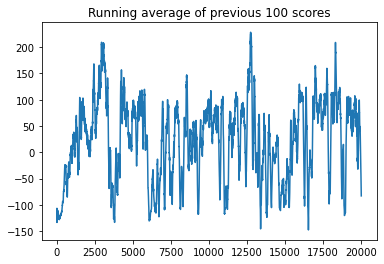

In [23]:
import gym
import numpy as np
#from agent import Agent
#from utils import plot_learning_curve, manage_memory
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#from buffer import ReplayBuffer
#from networks import ActorNetwork, CriticNetwork

if __name__ == '__main__':
    manage_memory()
    env = gym.make('BipedalWalker-v3')
    agent = Agent(input_dims=env.observation_space.shape, env=env,
                  n_actions=env.action_space.shape[0],
                  alpha=0.0001, beta=0.001)
    n_games = 20000

    figure_file = 'plot.png'

    best_score = env.reward_range[0]
    score_history = []
    load_checkpoint = False

    if load_checkpoint:
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.choose_action(observation, evaluate)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward,
                                   observation_, done)
            if not load_checkpoint:
                agent.learn()
            observation = observation_

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                agent.save_models()

        print('episode {} score {:.1f} avg score {:.1f}'.
              format(i, score, avg_score))

    if not load_checkpoint:
        x = [i+1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file)

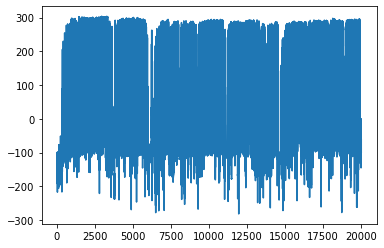

In [27]:
plt.plot(score_history)
plt.show()

In [28]:
len(score_history)

20000

In [29]:
np.array(score_history[:5001]).mean() 

26.555510734314865

In [30]:
np.array(score_history[:3001]).mean()

22.422696338348114

In [ ]:
import gym
import numpy as np
#from agent import Agent
#from utils import plot_learning_curve, manage_memory
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
if __name__ == '__main__':
    manage_memory()
    env = gym.make('BipedalWalker-v3')
    agent = Agent(input_dims=env.observation_space.shape, env=env,
                  n_actions=env.action_space.shape[0],
                  alpha=0.0001, beta=0.001)    
    n_games = 1



    best_score = env.reward_range[0]
    score_history = []
    load_checkpoint = True

    if load_checkpoint:
        agent.load_models()
        evaluate = True
    else:
        evaluate = False

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            env.render()
            action = agent.choose_action(observation, evaluate)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward,
                                   observation_, done)
            if not load_checkpoint:
                agent.learn()
            observation = observation_
        env.close()
